In [1]:
%cd /content/drive/MyDrive/Colab Notebooks/DeepShallow

/content/drive/MyDrive/Colab Notebooks/DeepShallow


In [2]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import random
import os
import torch

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import h5py


from tqdm.autonotebook import tqdm

from src.data_vis import visualize_data, visualize_data6, visualize_data7


<ipython-input-2-2a360f0e2879>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
taxi_zone_map_path_name = "/content/drive/MyDrive/Data/Data_Taxi/NYC_taxi_zoneMap2.csv"

taxi_zone_df = pd.read_csv("/content/drive/MyDrive/Data/Data_Taxi/Taxi_zone_NYC.csv")
filter = taxi_zone_df["Borough"] == "Manhattan"
manhattan_zones = list(taxi_zone_df[filter]['LocationID'])
# taxi_zone_map = pd.read_csv("/content/drive/MyDrive/Data/Data_Taxi/NYC_taxi_zoneMap.csv")
taxi_zone_map = pd.read_csv(taxi_zone_map_path_name)
taxi_zone_map = taxi_zone_map.fillna(0)


### Preprocessing:

In [ ]:
class TaxiData:

    def __init__(self, table, manhattan_zones):
        self.table = table
        # Create the bins for the intervals
        self.bins = [0, 15, 30, 45, 59]
        self.manhattan_zones = manhattan_zones

    def extract_pickup_days(self, pickup_mth):
        self.table_pu = self.table.copy()
        self.table_pu['pickup_day'] = self.table_pu['tpep_pickup_datetime'].dt.day
        self.table_pu['pickup_hour'] = self.table_pu['tpep_pickup_datetime'].dt.hour
        self.table_pu['pickup_yr_mth'] = self.table_pu['tpep_pickup_datetime'].dt.to_period('M')
        self.table_pu['DayofWeek'] = self.table_pu['tpep_pickup_datetime'].dt.dayofweek   # 0 for Monday, ... , Sunday = 6
        self.table_pu['DayofWeek_str'] = self.table_pu['tpep_pickup_datetime'].dt.day_name()

        # Add Min intervals:
        # Extract the minute from the 'time' column
        self.table_pu["pickup_min"] = self.table_pu["tpep_pickup_datetime"].dt.minute

        # Create the new column 'interval' using pd.cut()
        self.table_pu['pu_min_interval'] = pd.cut(self.table_pu['pickup_min'], self.bins, labels=False, include_lowest=True)

        filter = self.table_pu['pickup_yr_mth']  == pickup_mth # filter by month
        self.table_pu = self.table_pu[filter]
        return self.table_pu

    def only_manhatan_pickup(self):
        filter2 = self.table_pu['PULocationID'].isin(self.manhattan_zones)
        self.table_pu = self.table_pu[filter2]
        return self.table_pu


    def filter_pu_weekdays(self):
        filter6 = self.table_pu['DayofWeek'] <= 4
        self.table_pu = self.table_pu[filter6]
        return self.table_pu


    def filter_pickup_hours(self, start, end):
        filter1 = self.table_pu['pickup_hour'] <= end-1
        filter2 = start <= self.table_pu['pickup_hour']
        self.table_pu = self.table_pu[filter1 & filter2]
        return self.table_pu

    def groupby_pickup_min_intervals(self):
        gp_cols = ["pickup_day","pickup_hour", "pu_min_interval" , "PULocationID"]
        agg_cols = { "pickup_yr_mth" : "max", "passenger_count": "count", "total_amount": "sum" , "DayofWeek" : "max" , "DayofWeek_str" : "max"}
        return self.table_pu.groupby(gp_cols).agg(agg_cols).sort_values(['pickup_day','pickup_hour','pu_min_interval',"PULocationID"]).reset_index()

    def extract_dropoff_days(self, dropoff_mth):

        self.table_do = self.table.copy()
        self.table_do['dropoff_day'] = self.table_do['tpep_dropoff_datetime'].dt.day
        self.table_do['dropoff_hour'] = self.table_do['tpep_dropoff_datetime'].dt.hour
        self.table_do['dropoff_yr_mth'] = self.table_do['tpep_dropoff_datetime'].dt.to_period('M')
        self.table_do['DayofWeek'] = self.table_do['tpep_dropoff_datetime'].dt.dayofweek   # 0 for Monday, ... , Sunday = 6
        self.table_do['DayofWeek_str'] = self.table_do['tpep_dropoff_datetime'].dt.day_name()

        # Add Min intervals:
        # Extract the minute from the 'time' column
        self.table_do["dropoff_min"] = self.table_do["tpep_dropoff_datetime"].dt.minute

        # Create the new column 'interval' using pd.cut()
        self.table_do['do_min_interval'] = pd.cut(self.table_do['dropoff_min'], self.bins, labels=False, include_lowest=True)

        filter = self.table_do['dropoff_yr_mth']  == dropoff_mth # filter by month
        self.table_do = self.table_do[filter]
        return self.table_do

    def only_manhatan_dropoff(self):
        filter2 = self.table_do['DOLocationID'].isin(self.manhattan_zones)
        self.table_do = self.table_do[filter2]
        return self.table_do

    def filter_dropoff_hours(self, start, end):
        filter1 = self.table_do['dropoff_hour'] <= end-1
        filter2 = start <= self.table_do['dropoff_hour']
        self.table_do = self.table_do[filter1 & filter2]
        return self.table_do

    def filter_do_weekdays(self):
        filter6 = self.table_do['DayofWeek'] <= 4
        self.table_do = self.table_do[filter6]
        return self.table_do

    def groupby_dropoff_min_intervals(self):
        gp_cols = ["dropoff_day","dropoff_hour", "do_min_interval" , "DOLocationID"]
        agg_cols = { "dropoff_yr_mth" : "max", "passenger_count": "count", "total_amount": "sum" , "DayofWeek" : "max" , "DayofWeek_str" : "max"}
        return self.table_do.groupby(gp_cols).agg(agg_cols).sort_values(['dropoff_day','dropoff_hour','do_min_interval',"DOLocationID"]).reset_index()


def get_dropoff_pickup_table( table , manhattan_zones , month, do_start, do_end, pu_start, pu_end , only_weekdays = False):
    """
    Create a table with pickup and dropoff data for a given month and time interval.

    Parameters:
      - table (pandas DataFrame): The table with the taxi data
      - manhattan_zones (numpy array): A list of the taxi zones in Manhattan
      - month (str): The month to filter by
      - do_start (int): The starting hour for the dropoff time interval
      - do_end (int): The ending hour for the dropoff time interval
      - pu_start (int): The starting hour for the pickup time interval
      - pu_end (int): The ending hour for the pickup time interval

    Returns:
      - pickup_table (pandas DataFrame): The table with the pickup data
      - dropoff_table (pandas DataFrame): The table with the dropoff data
    """
    # Create an instance of the DataPreparation class
    data_prep = TaxiData(table, manhattan_zones)

    # Extract the pickup data
    data_prep.extract_pickup_days(month)

    # Filter the pickup data by the pickup time interval
    data_prep.filter_pickup_hours(pu_start, pu_end)

    #Only Manhattan:
    data_prep.only_manhatan_pickup()

    # Filter the pickup data by weekdays
    if only_weekdays: data_prep.filter_pu_weekdays()

    # Group the pickup data by day, hour, and 15 min intervals
    pickup_table = data_prep.groupby_pickup_min_intervals()

    # Extract the dropoff data
    data_prep.extract_dropoff_days(month)

    # Filter the dropoff data by the dropoff time interval
    data_prep.filter_dropoff_hours(do_start, do_end)

    # Only Manhattan:
    data_prep.only_manhatan_dropoff()

    # Filter the dropoff data by weekdays
    if only_weekdays: data_prep.filter_do_weekdays()

    # Group the dropoff data by day, hour, and 15 min intervals
    dropoff_table = data_prep.groupby_dropoff_min_intervals()

    return pickup_table, dropoff_table

In [ ]:
# Test Data (2023):

do_start = 6
do_end = 10
pu_start = 16
pu_end = 20
only_weekdays= False

test_pickup= []
test_dropoff = []

for table_name in tqdm(os.listdir('/content/drive/MyDrive/Data/Data_Taxi/Yellow_Cap_NYC_2023_Test'), desc='Epoch'):
# for table_name in os.listdir('/content/drive/MyDrive/Data/Data_Taxi/Yellow_Cap_NYC_2023_Test'):
  table = pq.read_table(os.path.join("/content/drive/MyDrive/Data/Data_Taxi/Yellow_Cap_NYC_2023_Test", table_name ))
  table = table.to_pandas()
  month =  table_name.split("_")[-1].split('.')[0]
  table_pickup, table_dropoff = get_dropoff_pickup_table(table , manhattan_zones , month, do_start, do_end, pu_start, pu_end, only_weekdays)
  test_pickup.append(table_pickup)
  test_dropoff.append(table_dropoff)
test_pickup = pd.concat(test_pickup)
test_dropoff = pd.concat(test_dropoff)


test_pickup = test_pickup.sort_values(['pickup_yr_mth','pickup_day','pickup_hour',"PULocationID" ,'pu_min_interval']).reset_index(drop=True)
test_dropoff = test_dropoff.sort_values(['dropoff_yr_mth','dropoff_day','dropoff_hour',"DOLocationID" ,'do_min_interval']).reset_index(drop=True)


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
df = test_pickup.copy()

# Generate date strings and convert to datetime
df['date'] = df['pickup_yr_mth'].astype(str) + '-' + df['pickup_day'].astype(str) + ' ' + df['pickup_hour'].astype(str) + ':' + df['pu_min_interval'].astype(str)

df['datetime'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M')

# Convert the datetime column to a list
date_list = df['datetime'].tolist()

date_list.sort()
len(date_list)

135258

In [ ]:
date_list = list(set(date_list))
date_list.sort()
len(date_list)

2416

In [ ]:
# 2021 and 2022 Data:
do_start = 6
do_end = 10
pu_start = 16
pu_end = 20
only_weekdays= False

train_pickup= []
train_dropoff = []


for table_name in tqdm(os.listdir('/content/drive/MyDrive/Data/Data_Taxi/Yellow_Cap_NYC_Train'), desc='Epoch'):
# for table_name in os.listdir('/content/drive/MyDrive/Data/Data_Taxi/Yellow_Cap_NYC_Train'):
  table = pq.read_table(os.path.join("/content/drive/MyDrive/Data/Data_Taxi/Yellow_Cap_NYC_Train", table_name ))
  table = table.to_pandas()
  month =  table_name.split("_")[-1].split('.')[0]
  table_pickup, table_dropoff = get_dropoff_pickup_table(table , manhattan_zones , month, do_start, do_end, pu_start, pu_end, only_weekdays)
  train_pickup.append(table_pickup)
  train_dropoff.append(table_dropoff)
train_pickup = pd.concat(train_pickup)
train_dropoff = pd.concat(train_dropoff)

train_pickup = train_pickup.sort_values(['pickup_yr_mth','pickup_day','pickup_hour',"PULocationID" ,'pu_min_interval']).reset_index(drop=True)
train_dropoff = train_dropoff.sort_values(['dropoff_yr_mth','dropoff_day','dropoff_hour',"DOLocationID" ,'do_min_interval']).reset_index(drop=True)

Epoch:   0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
print(len(test_pickup), len(train_pickup))

135258 663125


In [ ]:
# taxi_zone_map

In [ ]:
class DataTensorCreation:
  def __init__(self, taxi_zone_map):
    self.taxi_zone_map = taxi_zone_map


  def create_tensor(self, grouped_table):
    """
    Create a tensor from a grouped table and a taxi zone map.

    Parameters:
      - grouped_table (pandas DataFrame): The table that has been grouped by day, hour, and 15 min intervals
      - taxi_zone_map (numpy array): A map of the taxi zones, where each zone is represented by a unique integer

    Returns:
      - tensor (numpy array): A 3D tensor, where the first dimension represents the day,
      the second dimension represents the hour and 15 min intervals,
      and the third dimension represents the taxi zones and the passenger count in each zone.
    """
    all_data = []

    for month in grouped_table.pickup_yr_mth.unique():
      mnth_grouped_table = grouped_table[grouped_table['pickup_yr_mth'] == month]
      for day in mnth_grouped_table.pickup_day.unique():
        day_grouped_table = mnth_grouped_table[mnth_grouped_table['pickup_day'] == day]

        timeseries_traffic_maps = []
        for hour in day_grouped_table.pickup_hour.unique():
          for min_interval in day_grouped_table.pu_min_interval.unique():
            filterday2 = day_grouped_table['pickup_hour'] == hour
            filterday3 = day_grouped_table['pu_min_interval'] == min_interval
            day_grouped_table_h_m = day_grouped_table[filterday2 & filterday3]

            taxi_zone_traffic_map = np.zeros_like(self.taxi_zone_map)

            for row in day_grouped_table_h_m.itertuples():
              taxi_zone_traffic_map[self.taxi_zone_map == row.PULocationID] = row.passenger_count

            timeseries_traffic_maps.append(taxi_zone_traffic_map)
        all_data.append(np.stack(timeseries_traffic_maps))
    self.tensor  = np.stack(all_data).astype(int)
    return self.tensor

  def time_series_tensor(self, window_size=5):
    """
    This function generates time series tensors by dividing the input tensor into windows of a specified size and randomly masking a portion of the last data point in each window.

    Parameters:
    window_size (int, optional): The size of the windows to divide the input tensor into. Default is 5.

    Returns:
    tuple: A tuple containing two numpy arrays, the first being the stack of all the windows, and the second being the stack of the last data point in each window with a portion of it masked.
    """
    all_time_series = []
    output_tensor = []
    tensor = self.tensor

    for i in range(window_size,len(tensor)+1):
      all_time_series.append(np.copy(tensor[i-window_size:i]))
      output_tensor.append(np.copy(tensor[i-1,8:]))
      random_masking = random.randint(8, 14)
      all_time_series[-1][-1,random_masking:] = -1

    output_tensor = np.stack(output_tensor)
    all_time_series = np.stack(all_time_series)

    return all_time_series, output_tensor


  def mask_each_interval(self):
    """
    This function only predicts one time interval at a time, so it masks all the time intervals after the one being predicted.

    Returns:
    tuple: A tuple containing two numpy arrays, the first being the stack of all the windows, and the is a 2d tensor of the time interval that we want to predict.
        input_tensor: size (Day_interval (Day x intervals (7) ), time_intervals (8+7) , 2D tensor of zones (27 x 8) )
        output_tensor: size (Day_interval (Day x intervals (7) ) , 2D tensor of zones (27 x 8) -> Only outputs one interval per each input tensor)
    """
    input_tensor = []
    output_tensor = []
    tensor = self.tensor

    for i in range(1,len(tensor)+1):
      for j in range(8,16):
        input_tensor.append(np.copy(tensor[i-1])) # Copy the whole tensor
        output_tensor.append(np.copy(tensor[i-1,j]))  # Copy the time interval that we want to predict
        input_tensor[-1][j:] = -1 # Mask all the time intervals after the one being predicted
        input_tensor[-1] = np.delete(input_tensor[-1], -1, axis=0) # Remove the last interval from the input tensor

    output_tensor = np.stack(output_tensor)
    input_tensor = np.stack(input_tensor)

    return input_tensor, output_tensor

In [ ]:
class DataTensorCreationDropoffandPickup:
  def __init__(self, taxi_zone_map):
    self.taxi_zone_map = taxi_zone_map
    # Calculate the number of pixels for each zone
    self.zone_pixel_count = {zone: np.sum(np.sum(self.taxi_zone_map == zone)) for zone in np.unique(self.taxi_zone_map)}


  def create_tensor(self, grouped_pickup , grouped_dropoff, use_avg=False):
    """ Create a tensor from a grouped table and a taxi zone map.

    Args:
        grouped_pickup (pd.DataFrame): The Pick-up that has been grouped by day, hour, and 15 min intervals
        grouped_dropoff (pd.DataFrame): The Drop-off that has been grouped by day, hour, and 15 min intervals
    """
    pickup_data = []
    dropoff_data = []

    for month in grouped_pickup.pickup_yr_mth.unique():
      month_pickup = grouped_pickup[grouped_pickup['pickup_yr_mth'] == month]
      month_dropoff = grouped_dropoff[grouped_dropoff['dropoff_yr_mth'] == month]
      for day in month_pickup.pickup_day.unique():
        day_pickup = month_pickup[month_pickup['pickup_day'] == day]
        day_dropoff = month_dropoff[month_dropoff['dropoff_day'] == day]

        timeseries_pu_maps = []
        timeseries_do_maps = []
        for hour in day_pickup.pickup_hour.unique():
          for min_interval in day_pickup.pu_min_interval.unique():
            filterday2 = day_pickup['pickup_hour'] == hour
            filterday3 = day_pickup['pu_min_interval'] == min_interval
            day_pickup_h_m = day_pickup[filterday2 & filterday3]
            taxi_zone_pu_map = np.zeros_like(self.taxi_zone_map)
            for row in day_pickup_h_m.itertuples():
              if use_avg:
                avg_count = row.passenger_count / self.zone_pixel_count[row.PULocationID]
                taxi_zone_pu_map[self.taxi_zone_map == row.PULocationID] = avg_count
              else:
                taxi_zone_pu_map[self.taxi_zone_map == row.PULocationID] = row.passenger_count
            timeseries_pu_maps.append(taxi_zone_pu_map)
        pickup_data.append(np.stack(timeseries_pu_maps))

        for hour in day_dropoff.dropoff_hour.unique():
          for min_interval in day_dropoff.do_min_interval.unique():
            filterday4 = day_dropoff['dropoff_hour'] == hour
            filterday5 = day_dropoff['do_min_interval'] == min_interval
            day_dropoff_h_m = day_dropoff[filterday4 & filterday5]
            taxi_zone_do_map = np.zeros_like(self.taxi_zone_map)
            for row in day_dropoff_h_m.itertuples():
              if use_avg:
                avg_count = row.passenger_count / self.zone_pixel_count[row.DOLocationID]
                taxi_zone_do_map[self.taxi_zone_map == row.DOLocationID] = avg_count
              else:
                taxi_zone_do_map[self.taxi_zone_map == row.DOLocationID] = row.passenger_count
            timeseries_do_maps.append(taxi_zone_do_map)
        dropoff_data.append(np.stack(timeseries_do_maps))

    self.pickup_data_tensor  = np.stack(pickup_data).astype(int)
    self.dropoff_data_tensor  = np.stack(dropoff_data).astype(int)

    # To round up:
    # self.pickup_data_tensor  = np.ceil(np.stack(pickup_data)).astype(int)
    # self.dropoff_data_tensor  = np.ceil(np.stack(dropoff_data)).astype(int)

    return self.pickup_data_tensor, self.dropoff_data_tensor

  def time_series_tensor(self, window_size=5):
    """
    This function generates time series tensors by dividing the input tensor into windows of a specified size.

    Parameters:
    window_size (int, optional): The size of the windows to divide the input tensor into. Default is 5.

    Returns:
    all_time_series (numpy array): A 3D tensor, where the first dimension represents the day,
    output_tensor (numpy array): The last data point in each window.
    """
    all_time_series = []
    tensor = self.pickup_data_tensor

    for i in range(window_size,len(tensor)):
      all_time_series.append(np.copy(tensor[i-window_size:i]))

    all_time_series = np.stack(all_time_series)

    self.pickup_data_tensor = self.pickup_data_tensor[window_size:]
    self.dropoff_data_tensor = self.dropoff_data_tensor[window_size:]

    return  all_time_series,  self.pickup_data_tensor, self.dropoff_data_tensor

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def visualize_data( input  , taxi_zone_map, vmax = 300):

  # set the size of the plot
  plt.figure(figsize=(9,9))

  # create Color Map
  # define the colors and the positions of those colors
  colors = [ [0,'lightgray'], [0.02, "limegreen"], [.6, "yellow"] , [1, "orangered"] ]
  cmap_name = 'green_yellow_red'
  green_yellow_red = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

  # set the min and max values for the color scale
  vmin = 0
  vmax = vmax

  # create the heat map
  plt.imshow(input, cmap=green_yellow_red,  vmin=0, vmax=vmax)

  # remove x and y axis labels
  plt.xticks([])
  plt.yticks([])

  #loop through the matrix and add names to the values
  for i in range(taxi_zone_map.shape[0]):
      for j in range(taxi_zone_map.shape[1]):
          if int(np.array(taxi_zone_map)[i, j]) != 0:
                 plt.text(j, i, int(np.array(taxi_zone_map)[i, j]), ha='center', va='center', color='black' , fontsize=6)
          else:
                # Change the color of the box to White
                rect = plt.Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color='white')
                plt.gca().add_patch(rect)


  # add a color bar
  plt.colorbar()

  # show the plot
  plt.show()



In [ ]:
# test_pickup

In [ ]:
# test_dropoff

In [ ]:
# data_tensor_creation = DataTensorCreation( taxi_zone_map)

# tensor = data_tensor_creation.create_tensor(train_pickup)
# tensor_ts , tensor_ts_out = data_tensor_creation.time_series_tensor(window_size=5)
# tensor_one_inter_train , tensor_one_inter_train_out = data_tensor_creation.mask_each_interval()


# tensor_test = data_tensor_creation.create_tensor(test_pickup)
# tensor_ts_test , tensor_ts_test_out = data_tensor_creation.time_series_tensor(window_size=5)
# tensor_one_inter_test , tensor_one_inter_test_out = data_tensor_creation.mask_each_interval()


# print(tensor.shape, tensor_test.shape)
# print(tensor_one_inter_train.shape,tensor_one_inter_test_out.shape)
# print(np.array_equal(tensor_one_inter_test[-1][-1] , tensor_one_inter_test_out[-2]))

In [ ]:
# When you want pickup and dropoff data:
window_size =7

data_tensor_creation = DataTensorCreationDropoffandPickup( taxi_zone_map)

tensor_pu , tensor_do   = data_tensor_creation.create_tensor(train_pickup , train_dropoff, use_avg=True)
tensor_pu_ts , tensor_pu , tensor_do = data_tensor_creation.time_series_tensor(window_size=window_size)

# tensor_test_pu , tensor_test_do = data_tensor_creation.create_tensor(test_pickup , test_dropoff)
tensor_test_pu , tensor_test_do = data_tensor_creation.create_tensor(test_pickup , test_dropoff , use_avg=True)
tensor_test_pu_ts , tensor_test_pu , tensor_test_do  = data_tensor_creation.time_series_tensor(window_size=window_size)


print(tensor_pu.shape, tensor_do.shape, tensor_pu_ts.shape)
print(tensor_test_pu_ts.shape, tensor_test_pu.shape, tensor_test_do.shape)
print(np.array_equal(tensor_test_pu[0] , tensor_test_pu_ts[1][-1]))


import h5py

with h5py.File(f'/content/drive/MyDrive/Data/Data_Taxi/all_tensors_{window_size}_zone2.h5', 'w') as hf:
    hf.create_dataset("tensor_pu_ts", data=tensor_pu_ts)
    hf.create_dataset("tensor_pu", data=tensor_pu)
    hf.create_dataset("tensor_do", data=tensor_do)
    hf.create_dataset("tensor_test_pu_ts", data=tensor_test_pu_ts)
    hf.create_dataset("tensor_test_pu", data=tensor_test_pu)
    hf.create_dataset("tensor_test_do", data=tensor_test_do)


(723, 16, 58, 14) (723, 16, 58, 14) (723, 7, 16, 58, 14)
(144, 7, 16, 58, 14) (144, 16, 58, 14) (144, 16, 58, 14)
True


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np



def visualize_data6(taxi_zone_map_df):
    taxi_zone_map = taxi_zone_map_df.to_numpy()  # Convert to numpy array

    # Create a placeholder image with all zones in green (assuming our colormap spans from 0-1, and mid green is at 0.5 for example)
    display_map = np.ones_like(taxi_zone_map) * 0.5

    # Update zones with value 0 to light blue color value (assuming our colormap spans from 0-1, and light blue is at 0 for example)
    display_map[taxi_zone_map == 0] = 0

    # set the size of the plot
    plt.figure(figsize=(9,9))

    # Define a green colormap: from light blue (0) to light green (0.5) to dark green (1)
    cmap = plt.cm.colors.LinearSegmentedColormap.from_list("", ["lightblue","darkgray","green"])

    # Display the map using the green colormap
    plt.imshow(display_map, cmap=cmap, vmin=0, vmax=1)

    # remove x and y axis labels
    plt.xticks([])
    plt.yticks([])

    rows, cols = taxi_zone_map.shape

    # Check for boundary changes and draw lines
    for i in range(rows):
        for j in range(cols):
            # Check right neighbor
            if j < cols - 1 and taxi_zone_map[i, j] != taxi_zone_map[i, j + 1]:
                plt.plot([j + 0.5, j + 0.5], [i - 0.5, i + 0.5], color='gray')
            # Add line at the right edge of the map
            elif j == cols - 1:
                plt.plot([j + 0.5, j + 0.5], [i - 0.5, i + 0.5], color='gray')

            # Check neighbor below
            if i < rows - 1 and taxi_zone_map[i, j] != taxi_zone_map[i + 1, j]:
                plt.plot([j - 0.5, j + 0.5], [i + 0.5, i + 0.5], color='gray')
            # Add line at the bottom edge of the map
            elif i == rows - 1:
                plt.plot([j - 0.5, j + 0.5], [i + 0.5, i + 0.5], color='gray')

    # add zone numbers
    unique_zones = np.unique(taxi_zone_map)
    for zone in unique_zones:
        # Exclude the 0 zone
        if zone == 0:
            continue
        # get the coordinates of all cells in this zone
        y, x = np.where(taxi_zone_map == zone)
        # compute the centroid
        centroid_x = np.mean(x)
        centroid_y = np.mean(y)
        # add the label
        plt.text(centroid_x, centroid_y, str(int(zone)), ha='center', va='center', color='black', fontsize=6,  weight='bold', rotation=30)

    # show the plot
    plt.tight_layout()
    plt.show()




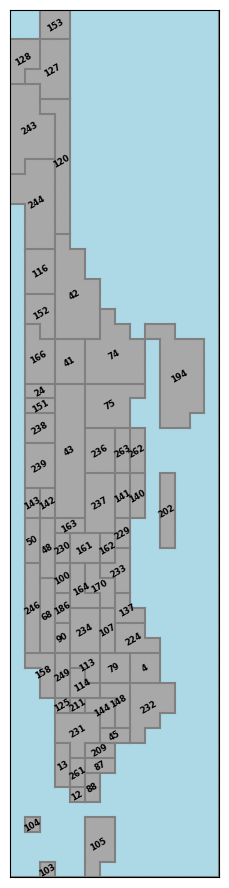

In [ ]:
visualize_data6(taxi_zone_map)

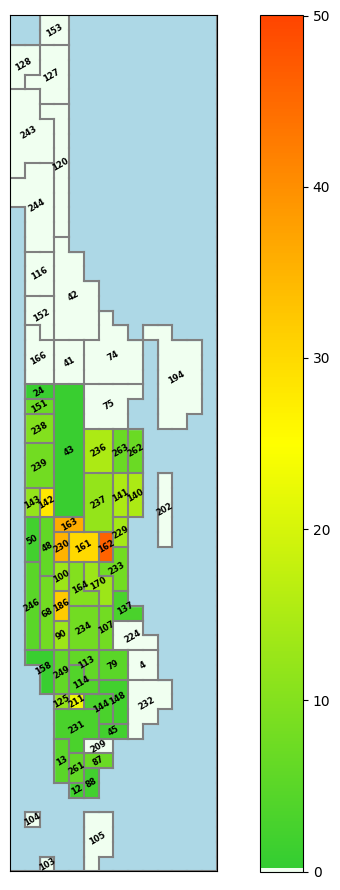

In [ ]:
visualize_data7(tensor_test_pu[-2][9] ,taxi_zone_map , 50) # This one is average based on size NOW (we should also then add them together at the end for single prediction if needed.)

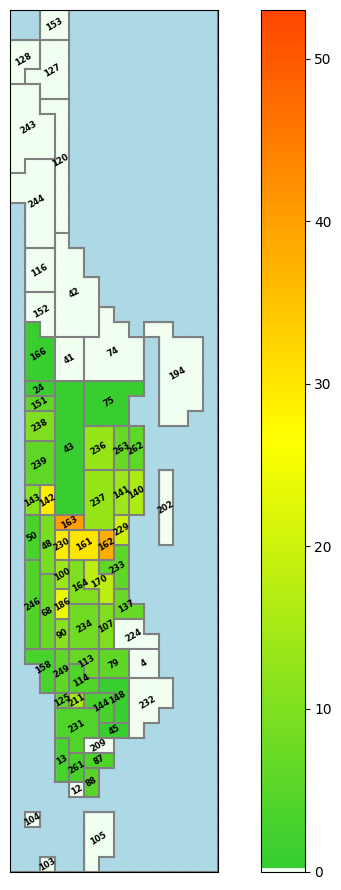

In [ ]:
visualize_data7(tensor_test_pu[-2][6] ,taxi_zone_map , np.max(tensor_test_pu[-2]))

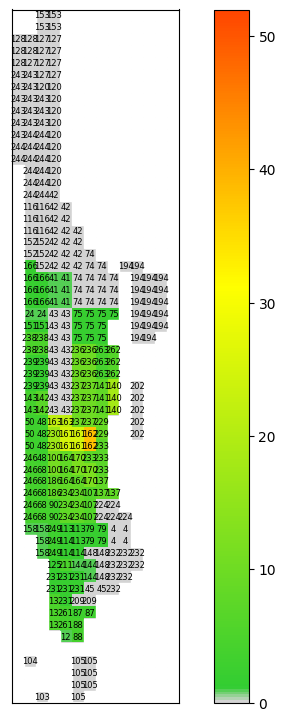

In [ ]:
visualize_data(tensor_test_do[-2][10] ,taxi_zone_map , np.max(tensor_test_pu[0]))

### Load the Data:

In [4]:
window_size =7
zone = "zone2" if "zoneMap2" in taxi_zone_map_path_name else "zone1"

with h5py.File(f'/content/drive/MyDrive/Data/Data_Taxi/all_tensors_{window_size}_{zone}.h5', 'r') as hf:
    tensor_pu = hf['tensor_pu'][:]
    tensor_pu_ts = hf['tensor_pu_ts'][:]
    tensor_do = hf['tensor_do'][:]
    tensor_test_pu_ts = hf['tensor_test_pu_ts'][:]
    tensor_test_pu = hf['tensor_test_pu'][:]
    tensor_test_do = hf['tensor_test_do'][:]

print(tensor_pu.shape, tensor_do.shape, tensor_pu_ts.shape)
print(tensor_test_pu_ts.shape, tensor_test_pu.shape, tensor_test_do.shape)
print(np.array_equal(tensor_test_pu[0] , tensor_test_pu_ts[1][-1]))

(723, 16, 58, 14) (723, 16, 58, 14) (723, 7, 16, 58, 14)
(144, 7, 16, 58, 14) (144, 16, 58, 14) (144, 16, 58, 14)
True


## Networks

Create a CNN - RNN:

For our base-lines:
1. Just CNN
2. Regular CNN-RNN
3. ConvLSTM

and then we will compare with the Deep shallow network.


In [5]:
# custom weighted loss function:
import torch.nn as nn

class WeightedMSELoss(nn.Module):
    def __init__(self, weight=10.0):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight

    def forward(self, output, target):
        # Create a mask with 'weight' for non-zero values and 1 for zero values
        mask = target.clone()
        mask[mask != 0] = self.weight
        mask[mask == 0] = 1.0

        # Compute the element-wise MSE loss
        loss = (output - target) ** 2

        # Weight the losses
        weighted_loss = loss * mask

        # Return the mean loss
        return weighted_loss.mean()

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, scheduler=None, print_losses=True):
    train_losses = []
    val_losses = []

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=print_losses)

    for epoch in tqdm(range(num_epochs), desc='Epoch'):

        if (epoch ) % validation_interval == 0:
            if print_losses:
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))
                print('-' * 10)

        # training phase
        model.train()
        running_loss = 0.0

        for data in train_loader:
            # check if the loader provides two inputs or just one
            if len(data) == 3:
                inputs1, inputs2, labels = data
                inputs1, inputs2 = inputs1.to(device), inputs2.to(device)
            else:
                inputs1, labels = data
                inputs1 = inputs1.to(device)

            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            if len(data) == 3:
                outputs = model(inputs1, inputs2)
            else:
                outputs = model(inputs1)
            loss = criterion(outputs, labels)

            # backward + optimize
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * len(labels)

        if scheduler:
            scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # validation phase
        if epoch % validation_interval == 0:
            if print_losses:
                print('Train Loss: {:.4f}'.format(epoch_loss))
            model.eval()
            running_loss = 0.0

            for data in val_loader:
                # check if the loader provides two inputs or just one
                if len(data) == 3:
                    inputs1, inputs2, labels = data
                    inputs1, inputs2 = inputs1.to(device), inputs2.to(device)
                else:
                    inputs1, labels = data
                    inputs1 = inputs1.to(device)

                labels = labels.to(device)

                # forward, no need to track history
                with torch.no_grad():
                    if len(data) == 3:
                        outputs = model(inputs1, inputs2)
                    else:
                        outputs = model(inputs1)
                    loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.item() * len(labels)

            epoch_loss = running_loss / len(val_loader.dataset)
            val_losses.append((epoch, epoch_loss))
            if print_losses:
                print('Validation Loss: {:.4f}'.format(epoch_loss))

            early_stopping(epoch_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

        # load the last checkpoint with the best model
        model.load_state_dict(torch.load('checkpoint.pt'))

    if not print_losses:
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('Last Train Loss: {:.4f}'.format(train_losses[-1]))
        print('Best Validation Loss: {:.4f}'.format(early_stopping.val_loss_min))

    return model, train_losses, val_losses, early_stopping.val_loss_min


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [7]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, color='blue', label='Training loss')
    plt.plot(*zip(*val_losses), color='red', label='Validation loss')  # Unpack the tuples
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Time')
    plt.show()


def show_loss(model , val_pu_ts , val_do , val_labels , taxi_zone_map , device):
    with torch.no_grad():
        if val_pu_ts is not None:
          val_outputs = model(val_pu_ts.to(device) , val_do.to(device))
        else:
          val_outputs = model( val_do.to(device))

    val_labels = val_labels.to("cpu")
    val_outputs = val_outputs.to("cpu")

    # Calculate the MSE of the validation outputs and validation data
    mse_loss = nn.MSELoss()
    val_mse = mse_loss(val_outputs , val_labels )

    # Calculate the MAE of the validation outputs and validation data
    mae_loss = nn.L1Loss()
    val_mae = mae_loss(val_outputs, val_labels)

    print(val_mse, val_mae)


    # np.array(taxi_zone_map)[9][3] #236
    # np.array(taxi_zone_map)[10][3] #237
    # np.array(taxi_zone_map)[11][3] #237


    rows, cols = np.where(taxi_zone_map == 237)
    val_mse_237 = mse_loss(val_outputs[:, :, rows, cols], val_labels[:, :, rows, cols])
    val_mae_237 = mae_loss(val_outputs[:, :, rows, cols], val_labels[:, :, rows, cols])

    print(f"validation MSE and MAE of block 237 (pixel) : {val_mse_237} , {val_mae_237} ")
    print(f"validation MSE and MAE of block 237 : {val_mse_237*len(rows)} , {val_mae_237*len(rows)} ")


    rows, cols = np.where(taxi_zone_map == 236)
    val_mse_236 = mse_loss(val_outputs[:, :, rows, cols], val_labels[:, :, rows, cols])
    val_mae_236 = mae_loss(val_outputs[:, :, rows, cols], val_labels[:, :, rows, cols])

    print(f"validation MSE and MAE of block 236 (pixel) : {val_mse_236} , {val_mae_236} ")
    print(f"validation MSE and MAE of block 236 : {val_mse_236*len(rows)} , {val_mae_236*len(rows)} ")


    print("Calculate the MAE of the validation outputs and validation data")
    mae_loss = nn.L1Loss(reduction='none')

    print(mae_loss(val_outputs, val_labels).shape)

    print(f"Maximum MSE: {torch.max(torch.mean(mae_loss(val_outputs, val_labels), (0,1) ))}")

    visualize_data7(torch.mean(mae_loss(val_outputs, val_labels), (0,1) ) ,taxi_zone_map , 10 )




def create_predicted_real_df(model, val_pu_ts, val_do, val_labels, taxi_zone_map, device, date_list):
    with torch.no_grad():
        if val_pu_ts is not None:
            val_outputs = model(val_pu_ts.to(device), val_do.to(device))
        else:
            val_outputs = model(val_do.to(device))

    val_labels = val_labels.to("cpu")
    val_outputs = val_outputs.to("cpu")

    # Create a dataframe
    rows_list = []

    for i in range(val_labels.shape[0]):  # Assuming first dimension is the batch size
        for m in range(val_labels.shape[1]):
            date = date_list[i+m].date()  # Extracting just the date
            hour = date_list[i+m].hour  # Extracting the hour
            minute = date_list[i+m].minute  # Extracting the minute

            # We start each row with date, hour, and minute
            row = {
                'Date': date,
                'Hour': hour,
                'Minute Interval': minute
            }

            for j in range(val_labels.shape[-2]):  # Assuming second to last dimension corresponds to rows in your map
                for k in range(val_labels.shape[-1]):  # Assuming last dimension corresponds to cols in your map
                    location_id = taxi_zone_map.iloc[j, k]

                    true_value = val_labels[i, m, j, k].item()
                    predicted_value = val_outputs[i,m, j, k].item()
                    predicted_value = max(int(np.floor(predicted_value)) , 0)

                    # Add true value and prediction for each location ID
                    row[f'{location_id}_gold'] = row.get(f'{location_id}_gold', 0) + true_value
                    row[f'{location_id}_pred'] = row.get(f'{location_id}_pred', 0) + predicted_value


            rows_list.append(row)

    df = pd.DataFrame(rows_list)


    return df


In [8]:
def model_num_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {total_params}")
    return

### 1. CNN (Conv-Deconv)

This one we don't use time series.

In [ ]:
### Model:
import torch
import torch.nn as nn

class ConvDeconvNet(nn.Module):
    """ PyTorch convolutional-deconvolutional network that takes a tensor with shape of (input_channel, 27, 8) as input and outputs a tensor with the shape of (output_channel, 27, 8)
    Args:
        nn: PyTorch's neural network module.
    """
    def __init__(self , input_channel , output_channel):
        """ Initialize the network
        Args:
            input_channel (PyTorch tensor): Input channel (time interval) of the network.
            output_channel (PyTorch tensor): Output channel (time interval of the network.
        """
        kernel_size = 5
        self.output_channel = output_channel
        super(ConvDeconvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channel, out_channels=16, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, padding=1)
        self.deconv1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=kernel_size, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=16, out_channels=output_channel, kernel_size=kernel_size, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.deconv1(x)
        x = torch.relu(x)
        x = self.deconv2(x)
        x = x.squeeze(1) if self.output_channel == 1 else x
        return x

#### Run the model V1:

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm

# Create an instance of the ConvDeconvNet
input_channel = 8
output_channel = 8
net = ConvDeconvNet( input_channel , output_channel)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters())

# # Split the data into training and validation sets
train_data = torch.tensor(tensor, dtype=torch.float32)
val_data = torch.tensor(tensor_test, dtype=torch.float32)

# Define the number of training epochs
num_epochs = 25

# Start the training loop
for epoch in tqdm(range(num_epochs), desc='Epoch'):
    running_loss = 0.0
    for i, data in enumerate(train_data):
        inputs, labels =  np.split(data, 2, axis=0)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print the average training loss for this epoch
    print(f'Epoch {epoch + 1} Loss: {running_loss / len(train_data)}')

    # Run the validation set through the network
    val_inputs , val_labels = np.split(val_data, 2, axis=1)
    val_outputs = net(val_inputs)
    val_loss = criterion(val_outputs, val_labels)
    print(f'Validation Loss: {val_loss.item()}')

NameError: ignored

In [ ]:
# Calculate the MSE of the validation outputs and validation data
mse_loss = nn.MSELoss()
val_mse = mse_loss(val_outputs, val_labels)

# Calculate the MAE of the validation outputs and validation data
mae_loss = nn.L1Loss()
val_mae = mae_loss(val_outputs, val_labels)

print(val_mse, val_mae)

# 237, 236

# np.array(taxi_zone_map)[9][3] #236
# np.array(taxi_zone_map)[10][3] #237
# np.array(taxi_zone_map)[11][3] #237


val_mse_237 = mse_loss(val_outputs[:,:,10,3], val_labels[:,:,10,3])
val_mae_237 = mae_loss(val_outputs[:,:,10,3], val_labels[:,:,10,3])

print(f"validation MSE and MAE of block 237 : {val_mse_237} , {val_mae_237} ")


val_mse_237 = mse_loss(val_outputs[:,:,11,3], val_labels[:,:,11,3])
val_mae_237 = mae_loss(val_outputs[:,:,11,3], val_labels[:,:,11,3])

print(f"validation MSE and MAE of block 237 : {val_mse_237} , {val_mae_237} ")

val_mse_236 = mse_loss(val_outputs[:,:,9,3], val_labels[:,:,9,3])
val_mae_236 = mae_loss(val_outputs[:,:,9,3], val_labels[:,:,9,3])

print(f"validation MSE and MAE of block 236 : {val_mse_236} , {val_mae_236} ")

tensor(24.1709, grad_fn=<MseLossBackward0>) tensor(2.4159, grad_fn=<MeanBackward0>)
validation MSE and MAE of block 237 : 217.490966796875 , 11.321914672851562 
validation MSE and MAE of block 237 : 237.01577758789062 , 11.800783157348633 
validation MSE and MAE of block 236 : 166.01028442382812 , 9.932001113891602 


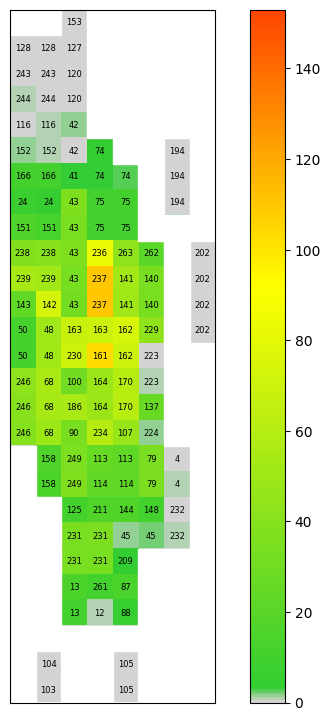

In [ ]:
visualize_data(val_outputs[2][-2].detach().numpy() ,taxi_zone_map , np.max(np.array(val_labels[2])))

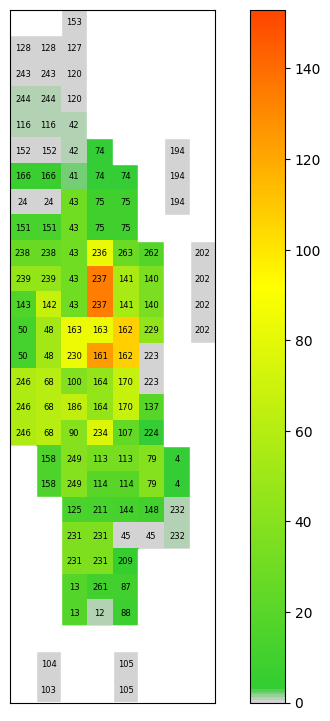

In [ ]:
visualize_data(val_labels[2][-2].detach().numpy() ,taxi_zone_map , np.max(np.array(val_labels[2])))

torch.Size([30, 8, 27, 8])
Maximum MSE: 14.011836051940918


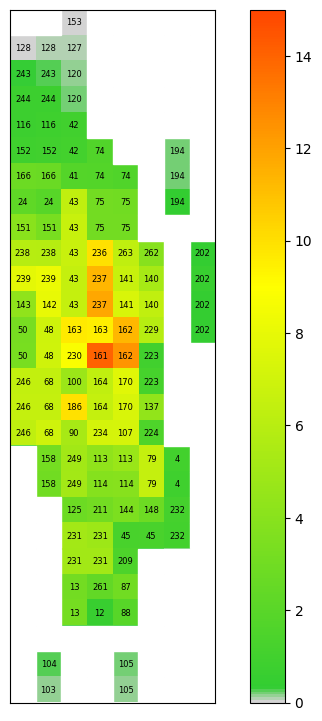

In [ ]:
# Calculate the MAE of the validation outputs and validation data
mae_loss = nn.L1Loss(reduction='none')

print(mae_loss(val_outputs, val_labels).shape)

print(f"Maximum MSE: {torch.max(torch.mean(mae_loss(val_outputs, val_labels), (0,1) ))}")


visualize_data(torch.mean(mae_loss(val_outputs, val_labels), (0,1) ).detach() ,taxi_zone_map , 15 )

In [ ]:
Val_236_161 = val_outputs[:,:, (9,11,12,13),3].detach().numpy().astype(int) #236, 237, 163, 161
Val_162 = val_outputs[:,:,12,4].detach().numpy().astype(int) # 162

GT_236_161 = val_labels[:,:, (9,11,12,13),3]
GT_162 = val_labels[:,:,12,4]

In [ ]:
import pandas as pd
import numpy as np


# create a list of column names
column_names = ['Pred 236', 'Pred 237', 'Pred 163', 'Pred 161' ]

# create a list of dates
dates = data_test['pickup_day'].unique()

# reshape the tensor into a 2D array
data = Val_236_161.reshape(-1, Val_236_161.shape[-1])

# create a pandas dataframe
df = pd.DataFrame(data, columns=column_names)

# add a 'date' column
df['date'] = np.repeat(dates, Val_236_161.shape[1])

# add an 'hour' column
df['hour'] = np.tile(np.arange(8), Val_236_161.shape[0])

# set the index to be a multi-index of date and hour
df = df.set_index(['date', 'hour'])

# sort the index
df = df.sort_index()



df["Predicted 162"] = Val_162.reshape(-1) # 162

df[["Real 236", "Real 237", "Real 163", "Real 161"]] = GT_236_161.reshape(-1, GT_236_161.shape[-1])
df["Real 162"] = GT_162.reshape(-1)


# display the dataframe
print(df.head())

           Pred 236  Pred 237  Pred 163  Pred 161  Predicted 162  Real 236  \
date hour                                                                    
1    0          111       128        83       126             89     131.0   
     1          104       116        76       120             86     106.0   
     2          100       112        76       119             84     117.0   
     3           95       111        75       115             82      88.0   
     4           90       109        79       128             90      81.0   

           Real 237  Real 163  Real 161  Real 162  
date hour                                          
1    0        141.0      95.0     138.0      98.0  
     1        144.0      94.0     124.0      86.0  
     2        139.0      92.0     113.0      90.0  
     3        104.0      90.0     116.0      74.0  
     4        123.0     104.0     145.0     104.0  


In [ ]:
df.to_csv("predicted_CSV.csv")
df.head(10)

Pred 236  Pred 237  Pred 163  Pred 161  Predicted 162  Real 236  \
date hour                                                                    
1    0          111       128        83       126             89     131.0   
     1          104       116        76       120             86     106.0   
     2          100       112        76       119             84     117.0   
     3           95       111        75       115             82      88.0   
     4           90       109        79       128             90      81.0   
     5           79        98        70       117             83      69.0   
     6           74        92        67       112             81      75.0   
     7           71        89        61       107             77      54.0   
2    0          126       135        81       117             81     131.0   
     1          117       126        78       114             80     136.0   

           Real 237  Real 163  Real 161  Real 162  
date hour                                          
1    0        141.0      95.0     138.0      98.0  
     1        144.0      94.0     124.0      86.0  
     2        139.0      92.0     113.0      90.0  
     3        104.0      90.0     116.0      74.0  
     4        123.0     104.0     145.0     104.0  
     5        100.0      70.0     111.0      86.0  
     6         93.0      84.0     142.0     100.0  
     7        106.0      70.0     122.0      86.0  
2    0        150.0      96.0     116.0      97.0  
     1        130.0      92.0     104.0      89.0

#### Train v2

Given 2d tensor with 15 channels (with maskes) and outputing 2d tensor with channel 1

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Create an instance of the ConvDeconvNet
input_channel = 15
output_channel = 1
model = ConvDeconvNet( input_channel , output_channel)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = WeightedMSELoss(weight=10.0)
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_data = torch.tensor(tensor_one_inter_train, dtype=torch.float32)
train_labels = torch.tensor(tensor_one_inter_train_out, dtype=torch.float32)
val_data = torch.tensor(tensor_one_inter_test, dtype=torch.float32)
val_labels = torch.tensor(tensor_one_inter_test_out, dtype=torch.float32)

# Define the batch size
batch_size = 120

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_data, val_labels),
    batch_size=batch_size,
    shuffle=False)



# Define the number of training epochs
num_epochs = 70


# Start the training loop
for epoch in tqdm(range(num_epochs), desc='Epoch'):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    # scheduler.step()
    # Print the average training loss for this epoch (every 5 epochs)
    if (epoch + 1) % 5 == 0:
      print(f'Epoch {epoch + 1} Loss: {running_loss / len(train_data)}')

      # Run the validation set through the network  (every 5 epochs)
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in val_loader:
              val_outputs = model(inputs)
              val_loss += criterion(val_outputs, labels).item() * inputs.size(0)
      print(f'Validation Loss: {val_loss / len(val_data)}')


Epoch:   0%|          | 0/70 [00:00<?, ?it/s]

Epoch 5 Loss: 24.367853099352693
Validation Loss: 29.75108893186051
Epoch 10 Loss: 22.51501373395528
Validation Loss: 27.74126061698459
Epoch 15 Loss: 21.344898968526763
Validation Loss: 26.764534148159406
Epoch 20 Loss: 20.746887429119788
Validation Loss: 25.99097637151251
Epoch 25 Loss: 20.253857390521325
Validation Loss: 26.22717100737111
Epoch 30 Loss: 20.082639067140345
Validation Loss: 25.5108423169875
Epoch 35 Loss: 19.90644549017083
Validation Loss: 25.77919915811905
Epoch 40 Loss: 19.62106733452784
Validation Loss: 25.25168656355498
Epoch 45 Loss: 19.697448861109066
Validation Loss: 25.251956510228037
Epoch 50 Loss: 19.650009272849722
Validation Loss: 24.842345686148334
Epoch 55 Loss: 19.345389300829744
Validation Loss: 24.801612790846665
Epoch 60 Loss: 19.088874229013104
Validation Loss: 25.45768797160774
Epoch 65 Loss: 19.167154442774105
Validation Loss: 25.18341135189233
Epoch 70 Loss: 19.147217815869475
Validation Loss: 24.268594160774686


In [ ]:
with torch.no_grad():
  val_outputs = model(val_data)

# Calculate the MSE of the validation outputs and validation data
mse_loss = nn.MSELoss()
val_mse = mse_loss(val_outputs, val_labels)

# Calculate the MAE of the validation outputs and validation data
mae_loss = nn.L1Loss()
val_mae = mae_loss(val_outputs, val_labels)

print(val_mse, val_mae)

# 237, 236

# np.array(taxi_zone_map)[9][3] #236
# np.array(taxi_zone_map)[10][3] #237
# np.array(taxi_zone_map)[11][3] #237


val_mse_237 = mse_loss(val_outputs[:,10,3], val_labels[:,10,3])
val_mae_237 = mae_loss(val_outputs[:,10,3], val_labels[:,10,3])

print(f"validation MSE and MAE of block 237 : {val_mse_237} , {val_mae_237} ")


val_mse_237 = mse_loss(val_outputs[:,11,3], val_labels[:,11,3])
val_mae_237 = mae_loss(val_outputs[:,11,3], val_labels[:,11,3])

print(f"validation MSE and MAE of block 237 : {val_mse_237} , {val_mae_237} ")

val_mse_236 = mse_loss(val_outputs[:,9,3], val_labels[:,9,3])
val_mae_236 = mae_loss(val_outputs[:,9,3], val_labels[:,9,3])

print(f"validation MSE and MAE of block 236 : {val_mse_236} , {val_mae_236} ")

tensor(24.2686) tensor(2.4269)
validation MSE and MAE of block 237 : 210.5605926513672 , 11.389117240905762 
validation MSE and MAE of block 237 : 211.47975158691406 , 11.380758285522461 
validation MSE and MAE of block 236 : 211.9320831298828 , 11.237253189086914 


Maximum MSE: 13.768498420715332
torch.Size([1208, 27, 8])


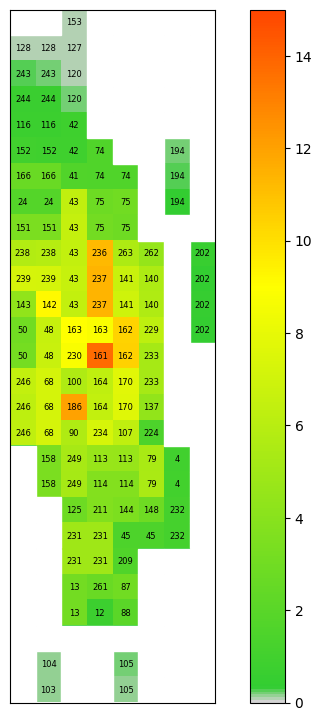

In [ ]:
# Calculate the MAE of the validation outputs and validation data
mae_loss = nn.L1Loss(reduction='none')

print(f"Maximum MSE: {torch.max(torch.mean(mae_loss(val_outputs, val_labels), (0) ))}")

print(mae_loss(val_outputs, val_labels).shape)

visualize_data(torch.mean(mae_loss(val_outputs, val_labels), (0) ).detach() ,taxi_zone_map , 15 )

#### Train v3

Given the Morning Dropoffs, predict afternoon pickups.

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Create an instance of the ConvDeconvNet
input_channel = 16
output_channel = 16
model = ConvDeconvNet( input_channel , output_channel).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_data = torch.tensor(tensor_do, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_data = torch.tensor(tensor_test_do, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 120

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_data, val_labels),
    batch_size=batch_size,
    shuffle=False)



# Define the number of training epochs
num_epochs = 300
validation_interval = 5
patience = 5
print_losses = False

model, train_losses, val_losses, val_loss_min = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, scheduler=None, print_losses=print_losses)

# # Start the training loop
# for epoch in tqdm(range(num_epochs), desc='Epoch'):
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * inputs.size(0)
#     # scheduler.step()
#     # Print the average training loss for this epoch (every 5 epochs)
#     if (epoch + 1) % 5 == 0:
#       print(f'Epoch {epoch + 1} Loss: {running_loss / len(train_data)}')

#       # Run the validation set through the network  (every 5 epochs)
#       val_loss = 0.0
#       with torch.no_grad():
#           for inputs, labels in val_loader:
#               val_outputs = model(inputs)
#               val_loss += criterion(val_outputs, labels).item() * inputs.size(0)
#       print(f'Validation Loss: {val_loss / len(val_data)}')


Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping
Epoch 131/300
Last Train Loss: 21.0856
Best Validation Loss: 24.5164


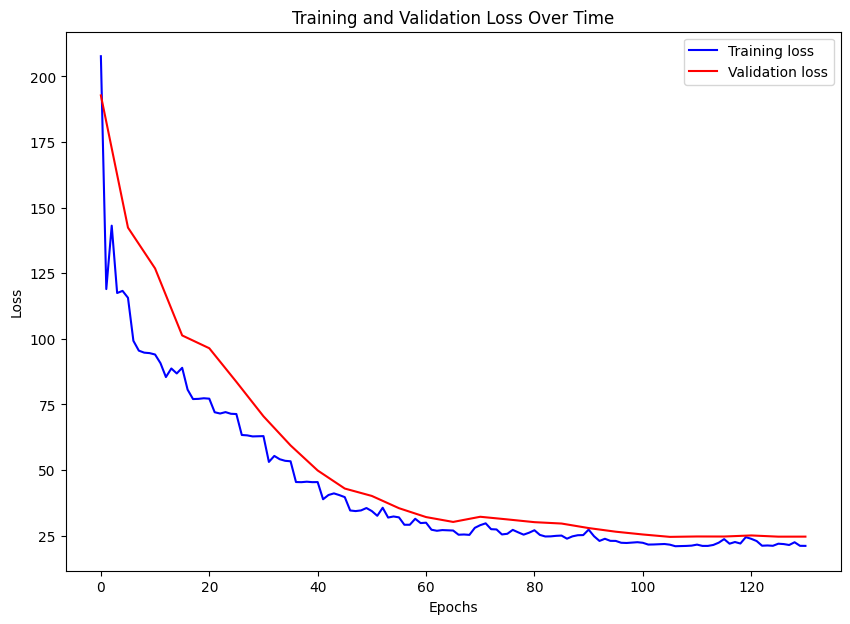

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
val_labels.shape

torch.Size([144, 16, 27, 8])

tensor(24.6108) tensor(2.5948)
validation MSE and MAE of block 237 (pixel) : 79.01937866210938 , 7.059410572052002 
validation MSE and MAE of block 237 : 158.03875732421875 , 14.118821144104004 
validation MSE and MAE of block 236 (pixel) : 297.0107421875 , 13.658044815063477 
validation MSE and MAE of block 236 : 297.0107421875 , 13.658044815063477 
Calculate the MAE of the validation outputs and validation data
torch.Size([144, 16, 27, 8])
Maximum MSE: 20.75274658203125


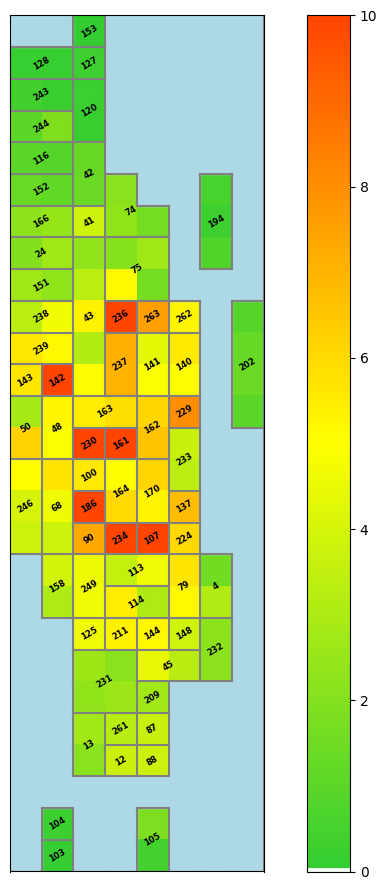

In [ ]:
show_loss(model , None , val_data , val_labels , taxi_zone_map , device)

In [ ]:
df =  create_predicted_real_df(model,  None , val_data , val_labels , taxi_zone_map , device, date_list[window_size*16:])

In [ ]:
df.to_csv("CNN_Morning_for_Night_results.csv")

### 2. CNN-RNN

In [ ]:

import torch
import torch.nn as nn

#

# CNN Layer:
class CNN(nn.Module):
    def __init__(self , in_channels, out_channels):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.pool1(out)
        return out

# RNN Layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        # print(out[:, -1, :].shape)
        out = self.fc(out[:, -1, :]) # Last output of ther model
        return out

# Main network:
# class CNN_RNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(CNN_RNN, self).__init__()
#         self.cnn = CNN()
#         self.rnn = RNN(input_size, hidden_size, num_layers, num_classes)

#     def forward(self, x):
#         out_cnns = []
#         for x_t_stamp in x:
#           out = self.cnn(x_t_stamp)
#           print(out.shape)
#           out = out.reshape(out.size(0), out.size(1), -1)
#           print(out.shape)
#           out_cnns.append(out)
#         out_cnns = torch.stack(out_cnns)
#         print(out_cnns.shape)
#         out = self.rnn(out_cnns)
#         print(out.shape)
#         return out

class CNN_RNN(nn.Module):
    def __init__(self, in_channels, out_channels, input_size, hidden_size, num_layers, num_classes):
        super(CNN_RNN, self).__init__()
        self.cnn = CNN(in_channels, out_channels)
        self.rnn = RNN(input_size, hidden_size, num_layers, num_classes)

    def forward(self, x):
        cnn_outputs = []
        for i in range(x.size(1)):
            cnn_outputs.append(self.cnn(x[:, i, :, :, :]))
        cnn_outputs = torch.stack(cnn_outputs, dim=1)
        # print(cnn_outputs.shape)
        rnn_input = cnn_outputs.reshape(cnn_outputs.size(0), cnn_outputs.size(1), -1)
        # print(rnn_input.shape)
        out = self.rnn(rnn_input)
        out = out.reshape(out.shape[0],8,27,8)
        return out




In [ ]:
input = torch.randn(5 , 10, 16, 27, 8) # (batch , days (window)  , min_int (channels) , x , y )

In [ ]:
CNN_model = CNN(16,16)

In [ ]:
cnn_input = torch.randn(5 , 16, 27, 8) # (batch  , channels ( # intervals) , x , y )
cnn_output = CNN_model(cnn_input)
cnn_output.shape

torch.Size([5, 16, 13, 4])

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler


input_size = 16 * 13 * 4 # Output size of the CNN layer (16 Channel, 13 (x) , 4 (y) )
hidden_size = 128
num_layers = 2
num_classes =  8 * 27 * 8 # output size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the CNNRNN
model = CNN_RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

# # Split the data into training and validation sets
train_data = torch.tensor(tensor_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_ts_out, dtype=torch.float32)
val_data = torch.tensor(tensor_ts_test, dtype=torch.float32)
val_labels = torch.tensor(tensor_ts_test_out, dtype=torch.float32)


# Define the batch size
batch_size = 32

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_data, val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
num_epochs = 50


# Start the training loop
for epoch in tqdm(range(num_epochs), desc='Epoch'):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    # scheduler.step()
    # Print the average training loss for this epoch (every 10 epochs)
    if (epoch + 1) % 10 == 0:
      print(f'Epoch {epoch + 1} Loss: {running_loss / len(train_data)}')

      # Run the validation set through the network  (every 10 epochs)
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in val_loader:
              val_outputs = model(inputs)
              val_loss += criterion(val_outputs, labels).item() * inputs.size(0)
      print(f'Validation Loss: {val_loss / len(val_data)}')

    # # Run the validation set through the network
    # val_outputs = model(val_data)
    # val_loss = criterion(val_outputs, val_labels)
    # print(f'Validation Loss: {val_loss.item()}')

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 Loss: 65.85607920328776
Validation Loss: 56.10630798339844
Epoch 20 Loss: 61.428514811197914
Validation Loss: 53.316165924072266
Epoch 30 Loss: 59.7976909383138
Validation Loss: 54.037391662597656
Epoch 40 Loss: 57.46683308919271
Validation Loss: 54.250003814697266
Epoch 50 Loss: 57.22773996988932
Validation Loss: 54.01374816894531


In [ ]:
with torch.no_grad():
  val_outputs = model(val_data)

# Calculate the MSE of the validation outputs and validation data
mse_loss = nn.MSELoss()
val_mse = mse_loss(val_outputs, val_labels)

# Calculate the MAE of the validation outputs and validation data
mae_loss = nn.L1Loss()
val_mae = mae_loss(val_outputs, val_labels)

print(val_mse, val_mae)

# 237, 236

# np.array(taxi_zone_map)[9][3] #236
# np.array(taxi_zone_map)[10][3] #237
# np.array(taxi_zone_map)[11][3] #237


val_mse_237 = mse_loss(val_outputs[:,:,10,3], val_labels[:,:,10,3])
val_mae_237 = mae_loss(val_outputs[:,:,10,3], val_labels[:,:,10,3])

print(f"validation MSE and MAE of block 237 : {val_mse_237} , {val_mae_237} ")


val_mse_237 = mse_loss(val_outputs[:,:,11,3], val_labels[:,:,11,3])
val_mae_237 = mae_loss(val_outputs[:,:,11,3], val_labels[:,:,11,3])

print(f"validation MSE and MAE of block 237 : {val_mse_237} , {val_mae_237} ")

val_mse_236 = mse_loss(val_outputs[:,:,9,3], val_labels[:,:,9,3])
val_mae_236 = mae_loss(val_outputs[:,:,9,3], val_labels[:,:,9,3])

print(f"validation MSE and MAE of block 236 : {val_mse_236} , {val_mae_236} ")

tensor(48.5399) tensor(3.0998)
validation MSE and MAE of block 237 : 655.1849365234375 , 20.668161392211914 
validation MSE and MAE of block 237 : 655.1844482421875 , 20.668258666992188 
validation MSE and MAE of block 236 : 522.30517578125 , 18.541234970092773 


torch.Size([212, 8, 27, 8])


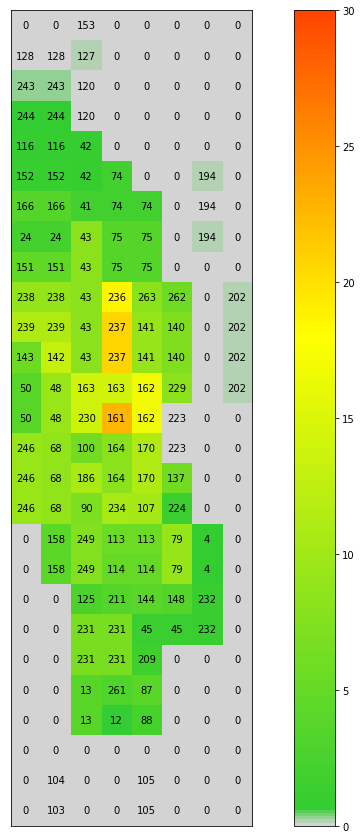

In [ ]:
# Calculate the MAE of the validation outputs and validation data
mae_loss = nn.L1Loss(reduction='none')

print(mae_loss(val_outputs, val_labels).shape)

visualize_data(torch.mean(mae_loss(val_outputs, val_labels), (0,1) ) ,taxi_zone_map , 30 )

In [ ]:
torch.mean(torch.mean(mae_loss(val_outputs, val_labels), (0,1) )  -  torch.rand(27,8)*1.5)

tensor(2.3483)

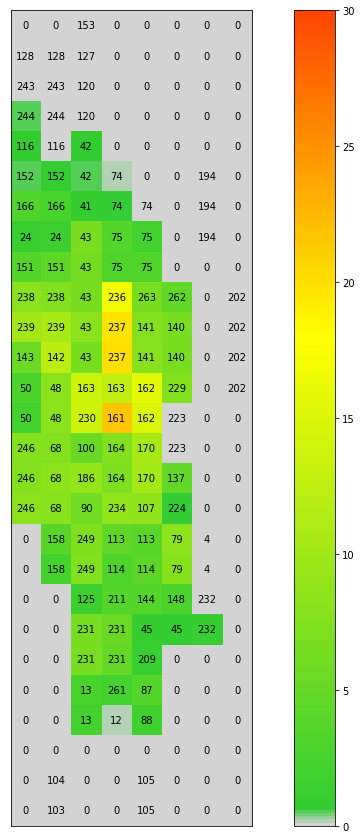

In [ ]:
visualize_data(torch.mean(mae_loss(val_outputs, val_labels), (0,1) )   -  torch.rand(27,8)*2 ,taxi_zone_map , 30 )

### 2.5 CNNRNN

For the pick up time-series + morning drop of times to predict afternoon pick-up times.

In [ ]:
import torch
from torch import nn


class HybridCNNRNN(nn.Module):
    def __init__(self, in_channels, mid_channels , out_channels, tensor_shape ,  window):
        super(HybridCNNRNN, self).__init__()

        # tensor_size = 27 * 8
        # tensor_size = 58 * 14
        self.tensor_shape = tensor_shape

        self.window = window
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=3, padding=1)
        self.rnn = nn.GRU(input_size=in_channels*np.prod(tensor_shape) , hidden_size=mid_channels*np.prod(tensor_shape), batch_first=True)

        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=mid_channels*2, out_channels=out_channels, kernel_size=3, padding=1)

    def forward(self, x, separate):
        batch_size = x.size(0)

        # apply convolution to the separate input
        separate = self.conv2(separate)
        separate = self.relu(separate)

        # Reshape the time-series tensor to fit the GRU input
        x = x.view(batch_size, self.window, -1)

        # apply RNN to time-series tensor
        output, _ = self.rnn(x)

        # Take the last output of the RNN
        output = output[:, -1, :].view(batch_size, -1, self.tensor_shape[0], self.tensor_shape[1])

        # Concatenate along channel dimenXsion
        output = torch.cat([output, separate], dim=1)

        # Apply another convolution
        output = self.conv3(output)
        output = self.relu(output)

        return output

In [ ]:
print(tensor_pu.shape, tensor_do.shape, tensor_pu_ts.shape)
print(tensor_test_pu_ts.shape, tensor_test_pu.shape, tensor_test_do.shape)

(723, 16, 58, 14) (723, 16, 58, 14) (723, 7, 16, 58, 14)
(144, 7, 16, 58, 14) (144, 16, 58, 14) (144, 16, 58, 14)


In [ ]:
in_channels = 16
mid_channels = 1
out_channels = 16
window = 7

model = HybridCNNRNN(in_channels,mid_channels,out_channels, (27,8) ,window)

input1 = torch.randn(2 , 7, 16, 27, 8) # (batch , days (window)  , min_int (channels) , x , y )
input2 = torch.randn(2 , 16, 27, 8) # (batch , days (window)  , min_int (channels) , x , y )

model(input1,input2).shape

model_num_params(model)

Number of parameters: 2381346


In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

in_channels = 16
mid_channels = 1
out_channels = 16
window = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the CNNRNN
model = HybridCNNRNN(in_channels,mid_channels,out_channels , tensor_test_do.shape[2:] ,window).to(device)
model_num_params(model)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 32

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
num_epochs = 300
validation_interval = 5
patience = 5
print_losses = False

model, train_losses, val_losses, val_loss_min = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, scheduler=None, print_losses=print_losses)


## Start the training loop
# for epoch in tqdm(range(num_epochs), desc='Epoch'):
#     running_loss = 0.0
#     for pu_inputs , do_inputs, labels in train_loader:
#         pu_inputs = pu_inputs.to(device)
#         do_inputs = do_inputs.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(pu_inputs , do_inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * inputs.size(0)
#     # scheduler.step()
#     # Print the average training loss for this epoch (every 10 epochs)
#     if (epoch + 1) % 10 == 0:
#       print(f'Epoch {epoch + 1} Loss: {running_loss / len(train_data)}')

#       # Run the validation set through the network  (every 10 epochs)
#       val_loss = 0.0
#       with torch.no_grad():
#           for  pu_inputs , do_inputs, labels in val_loader:
#               pu_inputs = pu_inputs.to(device)
#               do_inputs = do_inputs.to(device)
#               labels = labels.to(device)
#               val_outputs = model(pu_inputs , do_inputs)
#               val_loss += criterion(val_outputs, labels).item() * inputs.size(0)
#       print(f'Validation Loss: {val_loss / len(val_data)}')


Number of parameters: 33632010


Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

Early stopping
Epoch 186/300
Last Train Loss: 3.1424
Best Validation Loss: 3.5946


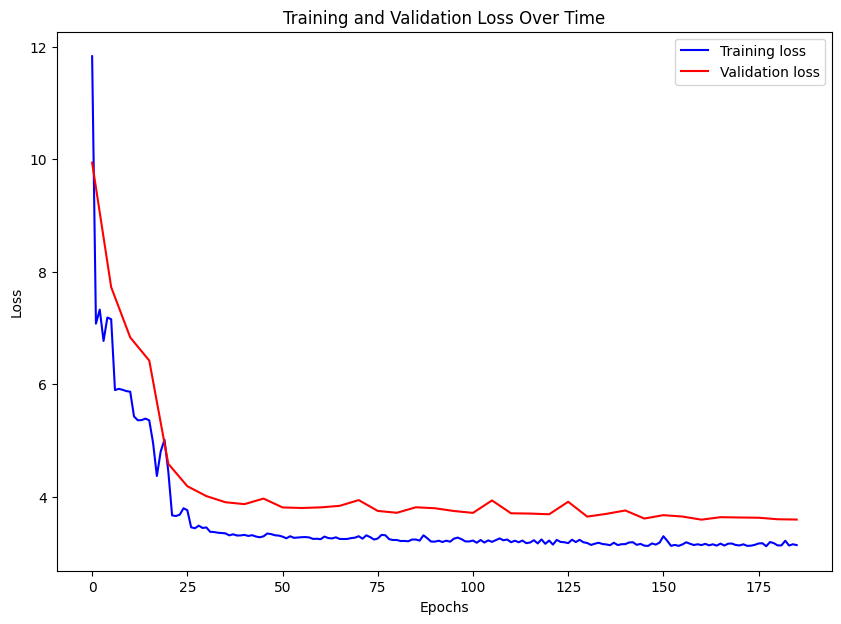

In [ ]:
plot_losses(train_losses, val_losses)

tensor(3.5968) tensor(0.6885)
validation MSE and MAE of block 237 (pixel) : 7.655985355377197 , 2.204033136367798 
validation MSE and MAE of block 237 : 61.24788284301758 , 17.632265090942383 
validation MSE and MAE of block 236 (pixel) : 13.246763229370117 , 2.8964099884033203 
validation MSE and MAE of block 236 : 79.48057556152344 , 17.378459930419922 
Calculate the MAE of the validation outputs and validation data
torch.Size([144, 16, 58, 14])
Maximum MSE: 9.826519966125488


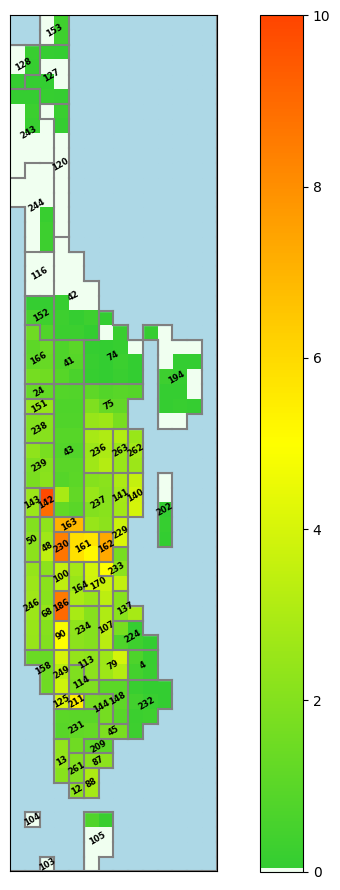

In [ ]:
show_loss(model , val_pu_ts , val_do , val_labels , taxi_zone_map , device)

In [ ]:
# df =  create_predicted_real_df(model,  val_pu_ts , val_do , val_labels , taxi_zone_map , device, date_list[window_size*16:])
# df.to_csv("CNN_LSTM_7Days_for_Night_results.csv")

### 3. ConvLSTM

In [ ]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        # h_next = o * torch.tanh(c_next)
        h_next = o * torch.relu(c_next) # Because the values are posetive

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
# # Intinlize the model
channels = 16

model_ConvLSTM = ConvLSTM(input_dim=channels,
                 hidden_dim=[64, 64,  8],
                 kernel_size=(3, 3),
                 num_layers=3,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)

# # Split the data into training and validation sets
train_data = torch.tensor(tensor_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_ts_out, dtype=torch.float32)
val_data = torch.tensor(tensor_ts_test, dtype=torch.float32)
val_labels = torch.tensor(tensor_ts_test_out, dtype=torch.float32)

NameError: ignored

In [ ]:
train_data[0:3].shape

torch.Size([3, 5, 16, 27, 8])

In [ ]:
layer_output_list , last_states_list = model_ConvLSTM(train_data[0:10])

In [ ]:
layer_output_list[0][:,-1].shape

torch.Size([10, 8, 27, 8])

In [ ]:
last_states_list[0][0].shape

torch.Size([10, 8, 27, 8])

In [ ]:
train_labels.shape

torch.Size([212, 8, 27, 8])

In [ ]:
last_states_list[0][0].shape

torch.Size([10, 8, 27, 8])

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler



channels = 16
hidden_dim=[ 8] # Hidden size of LSTM layers (last layer is the output channel size)
num_layers = len(hidden_dim) # It would be the length of above.
kernel_size = (3,3) # CNN Kernals

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Intinlize the ConvLSTM model
model_ConvLSTM = ConvLSTM(input_dim=channels,
                 hidden_dim=hidden_dim,
                 kernel_size= kernel_size,
                 num_layers=num_layers,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ConvLSTM.parameters(), lr=0.5)

# Define the learning rate decay scheduler
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

# # Split the data into training and validation sets
train_data = torch.tensor(tensor_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_ts_out, dtype=torch.float32)
val_data = torch.tensor(tensor_ts_test, dtype=torch.float32)
val_labels = torch.tensor(tensor_ts_test_out, dtype=torch.float32)

#Nomalize the Data:
train_data = torch.nn.functional.normalize(train_data , dim = 0)
val_data = torch.nn.functional.normalize(val_data , dim = 0)


# Define the batch size
batch_size = 32

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_data, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_data, val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
num_epochs = 200


# Start the training loop
for epoch in tqdm(range(num_epochs), desc='Epoch'):
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        layer_output_list , last_states_list  = model_ConvLSTM(inputs)
        loss = criterion(layer_output_list[0][:,-1], labels)
        # loss = criterion(last_states_list[0][-1], labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    # scheduler.step()
    # Print the average training loss for this epoch (every 10 epochs)
    if (epoch + 1) % 10 == 0:
      print(f'Epoch {epoch + 1} Loss: {running_loss / len(train_data)}')

      # Run the validation set through the network  (every 10 epochs)
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in val_loader:
              layer_output_list , last_states_list  = model_ConvLSTM(inputs)
              val_loss += criterion(layer_output_list[0][:,-1], labels).item() * inputs.size(0)
              # val_loss += criterion(last_states_list[0][-1], labels).item() * inputs.size(0)

      print(f'Validation Loss: {val_loss / len(val_data)}')

    # # Run the validation set through the network
    # val_outputs = model(val_data)
    # val_loss = criterion(val_outputs, val_labels)
    # print(f'Validation Loss: {val_loss.item()}')

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10 Loss: 223.77804795751032
Validation Loss: 223.7775098692696
Epoch 20 Loss: 223.76614149561468
Validation Loss: 223.76667987175708
Epoch 30 Loss: 223.7651395977668
Validation Loss: 223.7663649073187
Epoch 40 Loss: 223.76452406397405
Validation Loss: 223.76566386672687
Epoch 50 Loss: 223.76496829626694
Validation Loss: 223.76580090792675


KeyboardInterrupt: ignored

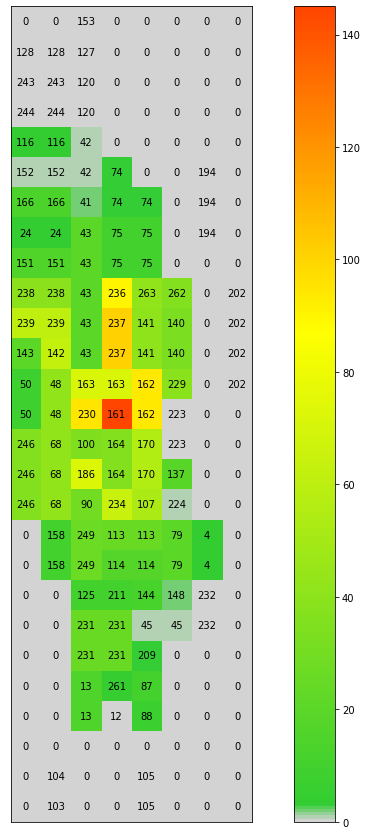

In [ ]:
visualize_data(labels[0][0].detach().numpy() ,taxi_zone_map , np.max(np.array(labels[0][0])))

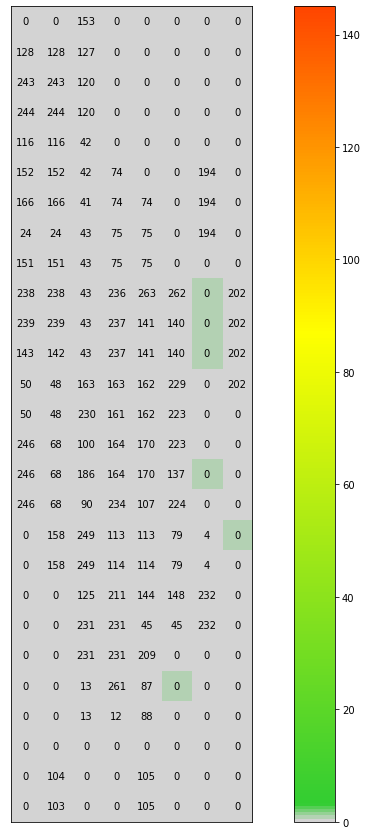

In [ ]:
visualize_data(layer_output_list[0][0][0][-1].detach().numpy() ,taxi_zone_map , np.max(np.array(labels[0][0])))

In [ ]:
# Calculate the MAE of the validation outputs and validation data
mae_loss = nn.L1Loss(reduction='none')

print(mae_loss(val_outputs, val_labels).shape)

visualize_data(torch.mean(mae_loss(val_outputs, val_labels), (0,1) ).detach() ,taxi_zone_map , 30 )

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([212, 8, 27, 8])) that is different to the input size (torch.Size([216, 8, 27, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
labels[0][0].numpy().astype(int)

array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  4,   4,   1,   0,   0,   0,   0,   0],
       [  1,   1,   1,   3,   0,   0,   0,   0],
       [ 14,  14,   2,   3,   3,   0,   0,   0],
       [  4,   4,  20,  10,  10,   0,   0,   0],
       [ 16,  16,  20,  10,  10,   0,   0,   0],
       [ 40,  40,  20,  90,  43,  36,   0,   0],
       [ 61,  61,  20, 101,  41,  33,   0,   0],
       [ 20,  63,  20, 101,  41,  33,   0,   0],
       [  8,  42,  72,  72,  94,  39,   0,   0],
       [  8,  42,  95, 145,  94,   0,   0,   0],
       [ 36,  43,  35,  36,  55,   0,   0,   0],
       [ 36,  43,  73,  36,  55,  19,   0,   0],
       [ 36,  43,  29,  65,  53,   1,   0,   0],
       [  0,  10,  27,  26,  26,  20,   4,   0],
       [  0,  10,  27,  18,  18,  20,   4,   0],
       [  0,   0,  10,  10,  12,   2,   0,   0],
       [  0,   0,  2

In [ ]:
last_states_list[0][0][0][-1].detach().numpy().astype(int)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

### 3.2. ConvLSTM V2

In [9]:
import torch
import torch.nn as nn


class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)

        combined_conv = self.conv(combined)

        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape ,  window):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = tensor_shape
        self.window = window

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = True
        self.bias = True
        self.return_all_layers = False

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

        self.conv1 = nn.Conv2d(in_channels=in_channels//2, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels, kernel_size=3, padding=1)

    def forward(self, input_tensor, input_standalone):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        input_standalone: todo
            4-D Tensor of shape (b, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor
        # print("ConvCell input: " , input_tensor.shape)
        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        # print("ConvCell output: " , len(layer_output_list) , layer_output_list[0].shape , layer_output_list[0][:, -1, :, :, :].shape)

        # Now process the input_tensor through the ConvLSTM and the standalone input through a separate Conv2D
        conv_out = self.conv1(layer_output_list[0][:, -1, :, :, :])
        standalone_out = self.conv2(input_standalone)
        # print("After conv1 and conv2 : " ,conv_out.shape,  standalone_out.shape)


        # Concatenate the outputs along the channel dimension
        combined_out = torch.cat((conv_out, standalone_out), dim=1)
        # print("After Concat: " ,combined_out.shape)

        # Pass the concatenated output through another Conv2D to get the final output
        final_out = self.conv3(combined_out)

        # print("After Conv3: " ,final_out.shape)


        return final_out

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, (self.height, self.width)))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param



In [10]:
input_dim = 16
kernel_size = (3,3)
num_layers = 3
hidden_dim=[64, 64,  8]
in_channels = 16
out_channels = 16
window = 7

#  ConvLSTM(input_dim=channels,
#                  hidden_dim=[64, 64,  8],
#                  kernel_size=(3, 3),
#                  num_layers=3,
#                  batch_first=True,
#                  bias=True,
#                  return_all_layers=False)

model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, (27,8) , window)

input1 = torch.randn(2 , 7, 16, 27, 8) # (batch , days (window)  , min_int (channels) , x , y )
input2 = torch.randn(2 , 16, 27, 8) # (batch , days (window)  , min_int (channels) , x , y )

model(input1,input2).shape

torch.Size([2, 16, 27, 8])

In [11]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

input_dim = 16
out_dim = input_dim//2
kernel_size = (3,3)
hidden_dim=[64, out_dim]
num_layers = len(hidden_dim)
# hidden_dim=[out_dim] # The last hidden_dim should be 8
in_channels = 16
out_channels = 16
window = 7


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the CNNRNN
model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:]  , window).to(device)

model_num_params(model)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
num_epochs = 200
validation_interval = 5
model, train_losses, val_losses, _ = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, validation_interval=validation_interval , patience = 5)

Number of parameters: 213456


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200
----------
Train Loss: 149.8478
Validation Loss: 75.1726
Validation loss decreased (inf --> 75.172582).  Saving model ...
Epoch 6/200
----------
Train Loss: 45.3423
Validation Loss: 42.3495
Validation loss decreased (75.172582 --> 42.349505).  Saving model ...
Epoch 11/200
----------
Train Loss: 30.4841
Validation Loss: 31.9232
Validation loss decreased (42.349505 --> 31.923158).  Saving model ...
Epoch 16/200
----------
Train Loss: 25.6103
Validation Loss: 26.7413
Validation loss decreased (31.923158 --> 26.741312).  Saving model ...
Epoch 21/200
----------
Train Loss: 21.6663
Validation Loss: 26.4176
Validation loss decreased (26.741312 --> 26.417588).  Saving model ...
Epoch 26/200
----------
Train Loss: 20.4980
Validation Loss: 24.3406
Validation loss decreased (26.417588 --> 24.340626).  Saving model ...
Epoch 31/200
----------
Train Loss: 18.5091
Validation Loss: 22.8638
Validation loss decreased (24.340626 --> 22.863802).  Saving model ...
Epoch 36/200
----------
Tra

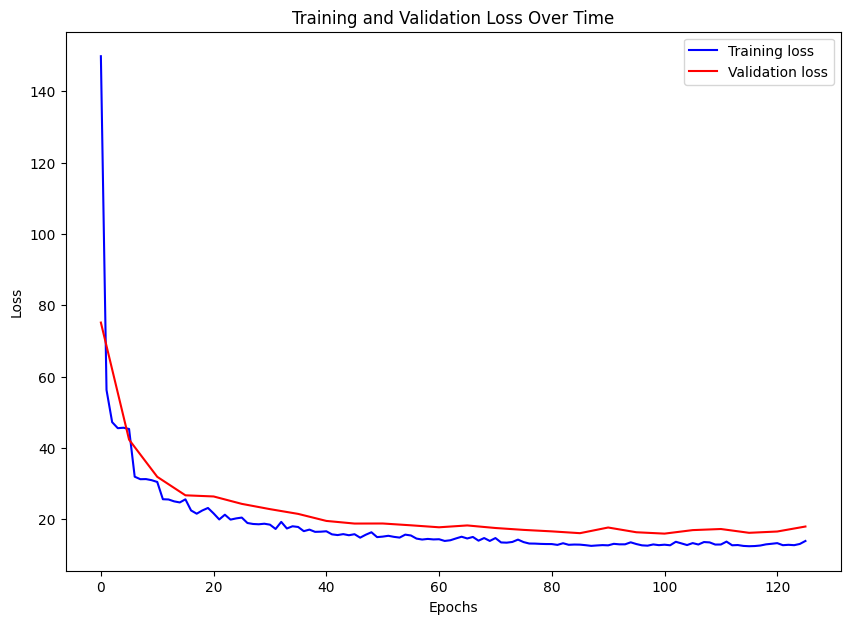

tensor(1.9016) tensor(0.5787)
validation MSE and MAE of block 237 (pixel) : 5.2210164070129395 , 1.7845878601074219 
validation MSE and MAE of block 237 : 41.768131256103516 , 14.276702880859375 
validation MSE and MAE of block 236 (pixel) : 7.020031929016113 , 2.0821290016174316 
validation MSE and MAE of block 236 : 42.12019348144531 , 12.49277400970459 
Calculate the MAE of the validation outputs and validation data
torch.Size([144, 16, 58, 14])
Maximum MSE: 6.798165798187256


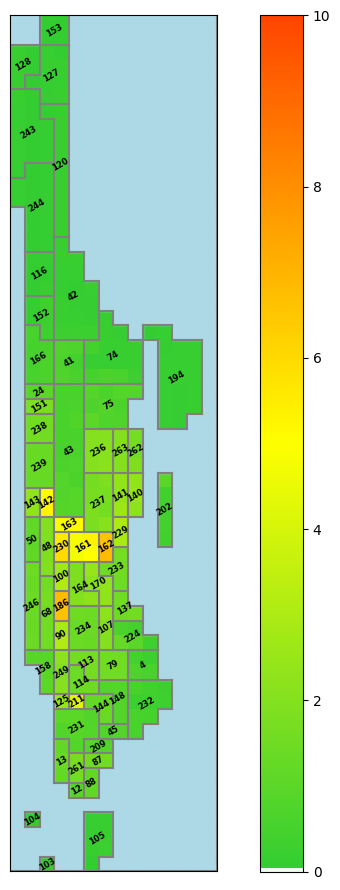

In [12]:
plot_losses(train_losses, val_losses)
show_loss(model , val_pu_ts , val_do , val_labels , taxi_zone_map , device)

In [ ]:
# df =  create_predicted_real_df(model,  val_pu_ts , val_do , val_labels , taxi_zone_map , device, date_list[window_size*16:])
# df.to_csv("ConvLSTM_7Days_for_night_results.csv")

##### Hyperparameter Tunning:

In [ ]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, randint
import numpy as np

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[16,16,out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 7

# Define the hyperparameters distributions to sample from
# Define the hyperparameters distributions to sample from
param_distributions = {
    # 'batch_size': [32, 64, 128],
    # 'lr':0.001,
    # 'initial_layers': randint(low= 1 , high= 10),
    'num_layers' : randint(low= 1 , high= 5),
    'hidden_dim' : [16,32,64] ,
    # you can add other parameters here
}

# Specify the number of iterations for the random search
n_iter = 10

# Create a random sampler of parameters
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter))


best_model = None
best_model_params = None
best_val_loss = float('inf')


for params in param_list:

    print('-' * 10)
    print(f"Training with parameters: {params}")
    # params['hidden_dim'] = 16
    # params['hidden_dim'] = 1
    # params['lr'] = 0.001

    num_layers = params['num_layers']
    hidden_dim = (num_layers-1) * [params['hidden_dim']] + [out_dim]
    print(hidden_dim)


    # Create a new instance of the model
    model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:]  , window).to(device)
    model_num_params(model)


    # Create a new optimizer with the current learning rate
    optimizer = torch.optim.Adam(model.parameters()) #, lr=params['lr'])
    criterion = nn.MSELoss()


    # Define the number of training epochs
    num_epochs = 500
    validation_interval = 5
    patience = 10
    # Train the model and get the final validation loss
    model, train_losses, val_losses, earlystop_val_loss = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, print_losses= False)

    # If this is the best model so far, save it
    final_val_loss = earlystop_val_loss
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model
        best_model_params = params

print(f"Best Hyoer-Paramter Tunning validation loss: {best_val_loss}, with parameters: {params}")


----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 4}
[32, 32, 32, 8]
Number of parameters: 222800


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 466/500
Last Train Loss: 1.3336
Best Validation Loss: 1.5987
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 4}
[64, 64, 64, 8]
Number of parameters: 803792


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 286/500
Last Train Loss: 1.3520
Best Validation Loss: 1.6808
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 4}
[16, 16, 16, 8]
Number of parameters: 70544


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 500/500
Last Train Loss: 1.4463
Best Validation Loss: 1.7497
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 213456


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 421/500
Last Train Loss: 1.2255
Best Validation Loss: 1.5438
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 1}
[8]
Number of parameters: 15056


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 336/500
Last Train Loss: 1.4584
Best Validation Loss: 1.7630
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 508624


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 386/500
Last Train Loss: 1.2858
Best Validation Loss: 1.6004
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 1}
[8]
Number of parameters: 15056


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 226/500
Last Train Loss: 1.6792
Best Validation Loss: 1.9182
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 2}
[32, 8]
Number of parameters: 75088


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 136/500
Last Train Loss: 1.6282
Best Validation Loss: 1.9521
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 213456


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 431/500
Last Train Loss: 1.2670
Best Validation Loss: 1.5590
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 2}
[32, 8]
Number of parameters: 75088


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 441/500
Last Train Loss: 1.3114
Best Validation Loss: 1.5758
Best Hyoer-Paramter Tunning validation loss: 1.5438201030095418, with parameters: {'hidden_dim': 32, 'num_layers': 2}


### 4. DeepShallow

Hello DeepShallow !


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class TimeDistributedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, initial_layers, window):
        super(TimeDistributedConv2d, self).__init__()

        self.convs = nn.ModuleList()

        layer_decrement = (initial_layers - 1) / (window - 1)

        for i in range(window):
            # Calculate the number of layers for this timestamp
            layers = initial_layers - int(round(i * layer_decrement))
            layers = max(1, layers)  # Ensure we have at least one layer

            # Create a sequential model representing the layers of this CNN
            cnn = nn.Sequential()
            for j in range(layers):
                # Use different in_channels for the first layer
                in_ch = in_channels if j == 0 else out_channels
                cnn.add_module(f"conv2d_{i}_{j}", nn.Conv2d(in_channels=in_ch, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
                cnn.add_module(f"relu_{i}_{j}", nn.ReLU())
            self.convs.append(cnn)

    def forward(self, x):
        # We expect x to be of size (batch_size, window, channels, height, width)
        batch_size, window, channels, height, width = x.shape
        output = []
        for i in range(window):
            # Select the input for this timestamp and remove the window dimension
            x_i = x[:, i] #.unsqueeze(1)
            # Apply the corresponding CNN
            output_i = self.convs[i](x_i)
            output.append(output_i)
        # Stack the output along the window dimension
        return torch.stack(output, dim=1)

class DeepShallowConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window, initial_layers):
        super(DeepShallowConvLSTM, self).__init__()

        self.conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape , window)
        # self.conv_lstm = ConvSelfAttention(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)

        self.time_distributed_cnn = TimeDistributedConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, initial_layers=initial_layers, window=window)
        self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)

    def forward(self, input_tensor, input_standalone):
        # Pass the input through the time-distributed CNN
        x = self.time_distributed_cnn(input_tensor)
        # pass the output + input_standalone through the ConvLSTM
        x = self.conv_lstm(x, input_standalone)
        # Pass the output through the final convolutional layer
        x = self.final_conv(x)
        return x


In [ ]:
input_dim = 16
kernel_size = (3,3)
num_layers = 3
hidden_dim=[64, 64,  8]
in_channels = 16
out_channels = 16
window = 5
initial_layers = 5

model = DeepShallowConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, (27,8)  , window, initial_layers = initial_layers)

input1 = torch.randn(2 , 5, 16, 27, 8) # (batch , days (window)  , min_int (channels) , x , y )
input2 = torch.randn(2 , 16, 27, 8) # (batch , days (window)  , min_int (channels) , x , y )

model(input1,input2).shape

torch.Size([2, 16, 27, 8])

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[64, out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 7
initial_layers = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the CNNRNN
model = DeepShallowConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:] ,  window, initial_layers ).to(device)

model_num_params(model)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
num_epochs = 500
validation_interval = 5
patience = 10
model, train_losses, val_losses, _  = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, validation_interval=validation_interval , patience = patience)

Number of parameters: 468656


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500
----------
Train Loss: 15.9460
Validation Loss: 10.7349
Validation loss decreased (inf --> 10.734854).  Saving model ...
Epoch 6/500
----------
Train Loss: 7.7260
Validation Loss: 8.1909
Validation loss decreased (10.734854 --> 8.190928).  Saving model ...
Epoch 11/500
----------
Train Loss: 5.7295
Validation Loss: 5.9516
Validation loss decreased (8.190928 --> 5.951617).  Saving model ...
Epoch 16/500
----------
Train Loss: 4.3785
Validation Loss: 5.1341
Validation loss decreased (5.951617 --> 5.134149).  Saving model ...
Epoch 21/500
----------
Train Loss: 3.7348
Validation Loss: 4.1992
Validation loss decreased (5.134149 --> 4.199193).  Saving model ...
Epoch 26/500
----------
Train Loss: 3.2517
Validation Loss: 3.7902
Validation loss decreased (4.199193 --> 3.790178).  Saving model ...
Epoch 31/500
----------
Train Loss: 2.9393
Validation Loss: 3.3414
Validation loss decreased (3.790178 --> 3.341367).  Saving model ...
Epoch 36/500
----------
Train Loss: 2.6880
Validati

tensor(1.8918) tensor(0.5214)
validation MSE and MAE of block 237 (pixel) : 5.101192951202393 , 1.772950291633606 
validation MSE and MAE of block 237 : 40.80954360961914 , 14.183602333068848 
validation MSE and MAE of block 236 (pixel) : 8.331134796142578 , 2.2882015705108643 
validation MSE and MAE of block 236 : 49.98680877685547 , 13.729209899902344 
Calculate the MAE of the validation outputs and validation data
torch.Size([146, 16, 58, 14])
Maximum MSE: 6.569174766540527


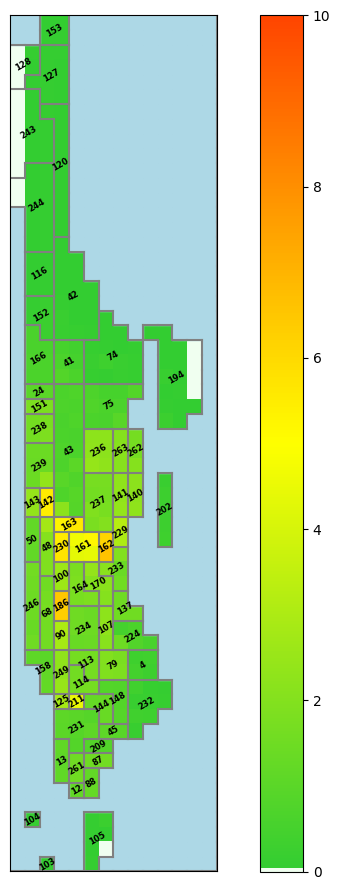

In [ ]:
plot_losses(train_losses, val_losses)
show_loss(model , val_pu_ts , val_do , val_labels , taxi_zone_map , device)

##### Hyper-Para Tunning:

In [ ]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, randint
import numpy as np

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[16,16,out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 5
initial_layers = 4

# Define the hyperparameters distributions to sample from
param_distributions = {
    # 'batch_size': [32, 64, 128],
    'lr': uniform(loc=0.001, scale=0.1-0.001),
    'initial_layers': randint(low= 1 , high= 10),
    'num_layers' : randint(low= 1 , high= 5),
    'hidden_dim' :randint(low= 2 , high= 128),
    # you can add other parameters here
}

# Specify the number of iterations for the random search
n_iter = 10

# Create a random sampler of parameters
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter))

best_model = None
best_val_loss = float('inf')

for params in param_list:
    print(f"Training with parameters: {params}")

    initial_layers = params['initial_layers']
    num_layers = params['hidden_dim']
    hidden_dim = (num_layers-1) * [params['hidden_dim']] + [out_dim]


    # Create a new instance of the model
    model = DeepShallowConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, window, initial_layers ).to(device)

    # Create a new optimizer with the current learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

    # Define the number of training epochs
    num_epochs = 100
    validation_interval = 5
    patience = 10
    # Train the model and get the final validation loss
    model, train_losses, val_losses, _  = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, print_losses= False)

    # If this is the best model so far, save it
    final_val_loss = val_losses[-1][1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model

print(f"Best validation loss: {best_val_loss}")


Training with parameters: {'hidden_dim': 30, 'initial_layers': 4, 'lr': 0.05543870105533997, 'num_layers': 4}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200
----------
Train Loss: 1259890.1994
Validation Loss: 757539.1875
Validation loss decreased (inf --> 757539.187500).  Saving model ...
Epoch 6/200
----------
Train Loss: 215853.8030
Validation Loss: 12241.2510
Validation loss decreased (757539.187500 --> 12241.250977).  Saving model ...
Epoch 11/200
----------
Train Loss: 4773.8236
Validation Loss: 1646.6400
Validation loss decreased (12241.250977 --> 1646.640015).  Saving model ...
Epoch 16/200
----------
Train Loss: 898.8225
Validation Loss: 328.2649
Validation loss decreased (1646.640015 --> 328.264893).  Saving model ...
Epoch 21/200
----------
Train Loss: 299.8837
Validation Loss: 222.0737
Validation loss decreased (328.264893 --> 222.073746).  Saving model ...
Epoch 26/200
----------
Train Loss: 235.8124
Validation Loss: 188.6901
Validation loss decreased (222.073746 --> 188.690109).  Saving model ...
Epoch 31/200
----------
Train Loss: 208.7205
Validation Loss: 172.8776
Validation loss decreased (188.690109 --> 172.87

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200
----------
Train Loss: 504.6571
Validation Loss: 205.9415
Validation loss decreased (inf --> 205.941452).  Saving model ...
Epoch 6/200
----------
Train Loss: 182.5103
Validation Loss: 134.7261
Validation loss decreased (205.941452 --> 134.726135).  Saving model ...
Epoch 11/200
----------
Train Loss: 140.7487
Validation Loss: 117.4325
Validation loss decreased (134.726135 --> 117.432510).  Saving model ...
Epoch 16/200
----------
Train Loss: 127.8512
Validation Loss: 107.5367
Validation loss decreased (117.432510 --> 107.536690).  Saving model ...
Epoch 21/200
----------
Train Loss: 117.0989
Validation Loss: 95.9705
Validation loss decreased (107.536690 --> 95.970490).  Saving model ...
Epoch 26/200
----------
Train Loss: 105.5554
Validation Loss: 83.5819
Validation loss decreased (95.970490 --> 83.581924).  Saving model ...
Epoch 31/200
----------
Train Loss: 97.0432
Validation Loss: 82.4008
Validation loss decreased (83.581924 --> 82.400764).  Saving model ...
Epoch 36/2

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200
----------
Train Loss: 9968.0973
Validation Loss: 6342.9180
Validation loss decreased (inf --> 6342.917969).  Saving model ...
Epoch 6/200
----------
Train Loss: 2340.7841
Validation Loss: 953.7380
Validation loss decreased (6342.917969 --> 953.738037).  Saving model ...
Epoch 11/200
----------
Train Loss: 326.0624
Validation Loss: 267.7749
Validation loss decreased (953.738037 --> 267.774872).  Saving model ...
Epoch 16/200
----------
Train Loss: 191.1574
Validation Loss: 142.6794
Validation loss decreased (267.774872 --> 142.679428).  Saving model ...
Epoch 21/200
----------
Train Loss: 138.8302
Validation Loss: 112.3858
Validation loss decreased (142.679428 --> 112.385788).  Saving model ...
Epoch 26/200
----------
Train Loss: 125.4796
Validation Loss: 106.5412
Validation loss decreased (112.385788 --> 106.541229).  Saving model ...
Epoch 31/200
----------
Train Loss: 118.3339
Validation Loss: 98.9830
Validation loss decreased (106.541229 --> 98.983009).  Saving model ..

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200
----------
Train Loss: 14021641.1717
Validation Loss: 7835616.0000
Validation loss decreased (inf --> 7835616.000000).  Saving model ...
Epoch 6/200
----------
Train Loss: 3031495.3714
Validation Loss: 214087.2500
Validation loss decreased (7835616.000000 --> 214087.250000).  Saving model ...
Epoch 11/200
----------
Train Loss: 67012.9098
Validation Loss: 13810.1914
Validation loss decreased (214087.250000 --> 13810.191406).  Saving model ...
Epoch 16/200
----------
Train Loss: 6715.5000
Validation Loss: 4241.0068
Validation loss decreased (13810.191406 --> 4241.006836).  Saving model ...
Epoch 21/200
----------
Train Loss: 1963.1472
Validation Loss: 1236.0270
Validation loss decreased (4241.006836 --> 1236.026978).  Saving model ...
Epoch 26/200
----------
Train Loss: 854.7803
Validation Loss: 744.7304
Validation loss decreased (1236.026978 --> 744.730408).  Saving model ...
Epoch 31/200
----------
Train Loss: 501.3130
Validation Loss: 352.2749
Validation loss decreased (7

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200
----------
Train Loss: 3999111.7807
Validation Loss: 1988574.0000
Validation loss decreased (inf --> 1988574.000000).  Saving model ...
Epoch 6/200
----------
Train Loss: 933530.5925
Validation Loss: 221877.0781
Validation loss decreased (1988574.000000 --> 221877.078125).  Saving model ...
Epoch 11/200
----------
Train Loss: 73196.7242
Validation Loss: 43746.0977
Validation loss decreased (221877.078125 --> 43746.097656).  Saving model ...
Epoch 16/200
----------
Train Loss: 17211.5634
Validation Loss: 9606.5566
Validation loss decreased (43746.097656 --> 9606.556641).  Saving model ...
Epoch 21/200
----------
Train Loss: 4709.7153
Validation Loss: 3958.6948
Validation loss decreased (9606.556641 --> 3958.694824).  Saving model ...
Epoch 26/200
----------
Train Loss: 1944.9143
Validation Loss: 1303.1520
Validation loss decreased (3958.694824 --> 1303.151978).  Saving model ...
Epoch 31/200
----------
Train Loss: 939.9665
Validation Loss: 627.6743
Validation loss decreased 

### 4.1 Deep Shallow V2

Shared Weights in same layer depth.

In [15]:

from torch.nn import functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeDistributedConv2d2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, initial_layers, window, reverse=False):
        super(TimeDistributedConv2d2, self).__init__()

        layer_decrement = (initial_layers - 1) / (window - 1)

        # Create a list of convolutional layers
        self.conv_layers = nn.ModuleList()
        for i in range(initial_layers):
            in_ch = in_channels if i == 0 else out_channels
            self.conv_layers.append(nn.Conv2d(in_channels=in_ch, out_channels=out_channels, kernel_size=kernel_size, padding=padding))

        # For each timestamp, create a list of indices into self.conv_layers
        self.conv_indices = []
        for i in range(window):
            layers = initial_layers - int(round(i * layer_decrement))
            layers = max(1, layers)
            self.conv_indices.append(list(range(layers)))

        # Reverse the order of conv_indices if the reverse parameter is True
        if reverse:
            self.conv_indices = self.conv_indices[::-1]

    def forward(self, x):
        batch_size, window, channels, height, width = x.shape
        output = []
        for i in range(window):
            x_i = x[:, i]
            for j in self.conv_indices[i]:
                x_i = F.relu(self.conv_layers[j](x_i))
            output.append(x_i)
        return torch.stack(output, dim=1)




class DeepShallowConvLSTM2(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels , tensor_shape , window, initial_layers, reverse=False):
        super(DeepShallowConvLSTM2, self).__init__()

        self.conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels,  out_channels, tensor_shape , window)
        # self.conv_lstm = ConvSelfAttention(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)
        self.time_distributed_cnn = TimeDistributedConv2d2(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, initial_layers=initial_layers, window=window , reverse=reverse)
        self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)

    def forward(self, input_tensor, input_standalone):
        # Pass the input through the time-distributed CNN
        x = self.time_distributed_cnn(input_tensor)
        # pass the output + input_standalone through the ConvLSTM
        x = self.conv_lstm(x, input_standalone)
        # Pass the output through the final convolutional layer
        x = self.final_conv(x)
        return x

In [16]:
input_dim = 16
kernel_size = (3,3)
num_layers = 3
hidden_dim=[16, 16,  8]
in_channels = 16
out_channels = 16
window = 5
initial_layers = 3
reverse_deepshallow = True

model = DeepShallowConvLSTM2(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, (27,8) ,window, initial_layers = initial_layers ,reverse=reverse_deepshallow)

input1 = torch.randn(2 , 5, 16, 27, 8) # (batch , days (window)  , min_int (channels) , x , y )
input2 = torch.randn(2 , 16, 27, 8) # (batch , days (window)  , min_int (channels) , x , y )

model(input1,input2).shape

torch.Size([2, 16, 27, 8])

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[64, out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 7
initial_layers = 3
reverse_deepshallow = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the CNNRNN
model = DeepShallowConvLSTM2(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:] , window, initial_layers, reverse=reverse_deepshallow).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
num_epochs = 600
validation_interval = 5
patience = 15
model, train_losses, val_losses, _ = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, validation_interval=validation_interval , patience = patience, print_losses = False)

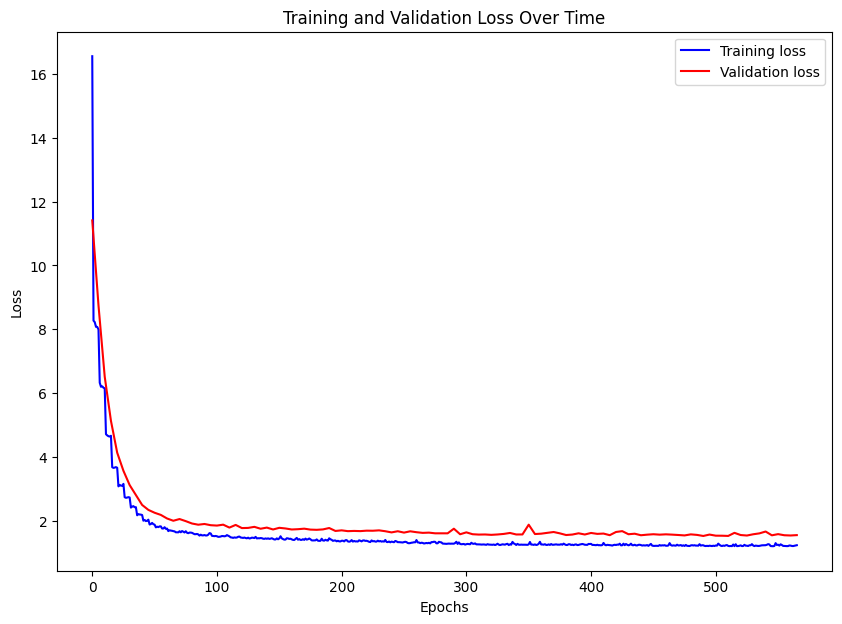

tensor(1.5490) tensor(0.4405)
validation MSE and MAE of block 237 (pixel) : 4.8454813957214355 , 1.750792145729065 
validation MSE and MAE of block 237 : 38.763851165771484 , 14.00633716583252 
validation MSE and MAE of block 236 (pixel) : 6.788656234741211 , 2.06528902053833 
validation MSE and MAE of block 236 : 40.731937408447266 , 12.39173412322998 
Calculate the MAE of the validation outputs and validation data
torch.Size([144, 16, 58, 14])
Maximum MSE: 6.217611789703369


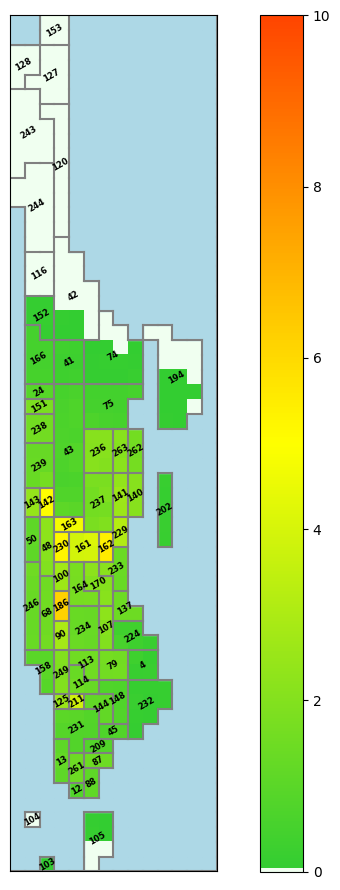

In [ ]:
plot_losses(train_losses, val_losses)
show_loss(model , val_pu_ts , val_do , val_labels , taxi_zone_map , device)

##### Hyper-Parameter Tunning:

In [ ]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, randint
import numpy as np

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[16,16,out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 7
initial_layers = 6
reverse_deepshallow = False


# Define the hyperparameters distributions to sample from
# Define the hyperparameters distributions to sample from
param_distributions = {
    # 'batch_size': [32, 64, 128],
    # 'lr':0.001,
    # 'initial_layers': randint(low= 1 , high= 10),
    'num_layers' : randint(low= 2 , high= 4),
    'hidden_dim' : [64] ,
    # you can add other parameters here
}

# Specify the number of iterations for the random search
n_iter = 10

# Create a random sampler of parameters
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter))


best_model = None
best_model_params = None
best_val_loss = float('inf')


for params in param_list:

    print('-' * 10)
    print(f"Training with parameters: {params}")
    # params['hidden_dim'] = 16
    # params['hidden_dim'] = 1
    # params['lr'] = 0.001

    num_layers = params['num_layers']
    hidden_dim = (num_layers-1) * [params['hidden_dim']] + [out_dim]
    print(hidden_dim)


    # Create a new instance of the model
    model = DeepShallowConvLSTM2(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:] , window, initial_layers, reverse=reverse_deepshallow).to(device)
    model_num_params(model)


    # Create a new optimizer with the current learning rate
    optimizer = torch.optim.Adam(model.parameters()) #, lr=params['lr'])
    criterion = nn.MSELoss()


    # Define the number of training epochs
    num_epochs = 500
    validation_interval = 5
    patience = 10
    # Train the model and get the final validation loss
    model, train_losses, val_losses, earlystop_val_loss = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, print_losses= False)

    # If this is the best model so far, save it
    final_val_loss = earlystop_val_loss
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model
        best_model_params = params

print(f"Best Hyoer-Paramter Tunning validation loss: {best_val_loss}, with parameters: {params}")


----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 234304


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 291/500
Last Train Loss: 1.3724
Best Validation Loss: 1.6415
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 234304


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 231/500
Last Train Loss: 1.3930
Best Validation Loss: 1.6816
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 234304


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 141/500
Last Train Loss: 1.5334
Best Validation Loss: 1.7215
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 522816


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 261/500
Last Train Loss: 1.5260
Best Validation Loss: 1.6943
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 522816


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 296/500
Last Train Loss: 1.5379
Best Validation Loss: 1.7042
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 522816


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 406/500
Last Train Loss: 1.4462
Best Validation Loss: 1.6766
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 522816


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 191/500
Last Train Loss: 1.4367
Best Validation Loss: 1.6341
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 522816


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, randint
import numpy as np

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[16,16,out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 7
initial_layers = 6
reverse_deepshallow = False


# Define the hyperparameters distributions to sample from
# Define the hyperparameters distributions to sample from
param_distributions = {
    # 'batch_size': [32, 64, 128],
    # 'lr':0.001,
    # 'initial_layers': randint(low= 1 , high= 10),
    'num_layers' : randint(low= 2 , high= 4),
    'hidden_dim' : [64] ,
    # you can add other parameters here
}

# Specify the number of iterations for the random search
n_iter = 10

# Create a random sampler of parameters
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter))


best_model = None
best_model_params = None
best_val_loss = float('inf')


for params in param_list:

    print('-' * 10)
    print(f"Training with parameters: {params}")
    # params['hidden_dim'] = 16
    # params['hidden_dim'] = 1
    # params['lr'] = 0.001

    num_layers = params['num_layers']
    hidden_dim = (num_layers-1) * [params['hidden_dim']] + [out_dim]
    print(hidden_dim)


    # Create a new instance of the model
    model = DeepShallowConvLSTM2(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:] , window, initial_layers, reverse=reverse_deepshallow).to(device)
    model_num_params(model)


    # Create a new optimizer with the current learning rate
    optimizer = torch.optim.Adam(model.parameters()) #, lr=params['lr'])
    criterion = nn.MSELoss()


    # Define the number of training epochs
    num_epochs = 500
    validation_interval = 5
    patience = 10
    # Train the model and get the final validation loss
    model, train_losses, val_losses, earlystop_val_loss = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, print_losses= False)

    # If this is the best model so far, save it
    final_val_loss = earlystop_val_loss
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model
        best_model_params = params

print(f"Best Hyoer-Paramter Tunning validation loss: {best_val_loss}, with parameters: {params}")


----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 229696


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 196/500
Last Train Loss: 1.4054
Best Validation Loss: 1.7282
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 524864


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 246/500
Last Train Loss: 1.3908
Best Validation Loss: 1.6684
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 229696


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 276/500
Last Train Loss: 1.3767
Best Validation Loss: 1.6791
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 524864


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 286/500
Last Train Loss: 1.3090
Best Validation Loss: 1.5936
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 524864


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 251/500
Last Train Loss: 1.5233
Best Validation Loss: 1.6965
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 229696


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

### 4.2 Deep Shallow V3

`+` Batch Normalization, Dropout, and LeakyReLU

In [ ]:
class TimeDistributedConv2d3(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, initial_layers, window):
        super(TimeDistributedConv2d3, self).__init__()

        layer_decrement = (initial_layers - 1) / (window - 1)

        # Create a list of convolutional layers
        self.conv_layers = nn.ModuleList()
        self.batchnorm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        for i in range(initial_layers):
            in_ch = in_channels if i == 0 else out_channels
            self.conv_layers.append(nn.Conv2d(in_channels=in_ch, out_channels=out_channels, kernel_size=kernel_size, padding=padding))
            self.batchnorm_layers.append(nn.BatchNorm2d(out_channels))
            self.dropout_layers.append(nn.Dropout2d(p=0.2))

        # For each timestamp, create a list of indices into self.conv_layers
        self.conv_indices = []
        for i in range(window):
            layers = initial_layers - int(round(i * layer_decrement))
            layers = max(1, layers)
            self.conv_indices.append(list(range(layers)))

    def forward(self, x):
        batch_size, window, channels, height, width = x.shape
        output = []
        for i in range(window):
            x_i = x[:, i]
            for j in self.conv_indices[i]:
                x_i = self.conv_layers[j](x_i)
                x_i = F.leaky_relu(self.batchnorm_layers[j](x_i))
                x_i = self.dropout_layers[j](x_i)
            output.append(x_i)
        return torch.stack(output, dim=1)


class DeepShallowConvLSTM3(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape , window, initial_layers):
        super(DeepShallowConvLSTM3, self).__init__()

        # self.conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)
        self.conv_lstm = ConvSelfAttention(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)


        self.time_distributed_cnn = TimeDistributedConv2d3(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, initial_layers=initial_layers, window=window)
        self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)

    def forward(self, input_tensor, input_standalone):
        # Pass the input through the time-distributed CNN
        x = self.time_distributed_cnn(input_tensor)
        # pass the output + input_standalone through the ConvLSTM
        x = self.conv_lstm(x, input_standalone)
        # Pass the output through the final convolutional layer
        x = self.final_conv(x)
        return x

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[8,8, out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 5
initial_layers = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the CNNRNN
model = DeepShallowConvLSTM3(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels,tensor_do.shape[-2:] , window, initial_layers ).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
scheduler = None
num_epochs = 1000
validation_interval = 5
patience = 15
model, train_losses, val_losses, _ = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, validation_interval=validation_interval , patience = patience, scheduler = scheduler , print_losses= True)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000
----------
Train Loss: 16.8081
Validation Loss: 10.5829
Validation loss decreased (inf --> 10.582875).  Saving model ...
Epoch 6/1000
----------
Train Loss: 6.8305
Validation Loss: 6.7561
Validation loss decreased (10.582875 --> 6.756062).  Saving model ...
Epoch 11/1000
----------
Train Loss: 4.7930
Validation Loss: 5.1674
Validation loss decreased (6.756062 --> 5.167449).  Saving model ...
Epoch 16/1000
----------
Train Loss: 3.8875
Validation Loss: 4.3568
Validation loss decreased (5.167449 --> 4.356813).  Saving model ...
Epoch 21/1000
----------
Train Loss: 3.3505
Validation Loss: 3.6506
Validation loss decreased (4.356813 --> 3.650641).  Saving model ...
Epoch 26/1000
----------
Train Loss: 2.9470
Validation Loss: 3.1847
Validation loss decreased (3.650641 --> 3.184693).  Saving model ...
Epoch 31/1000
----------
Train Loss: 2.5813
Validation Loss: 2.7777
Validation loss decreased (3.184693 --> 2.777707).  Saving model ...
Epoch 36/1000
----------
Train Loss: 2.3081


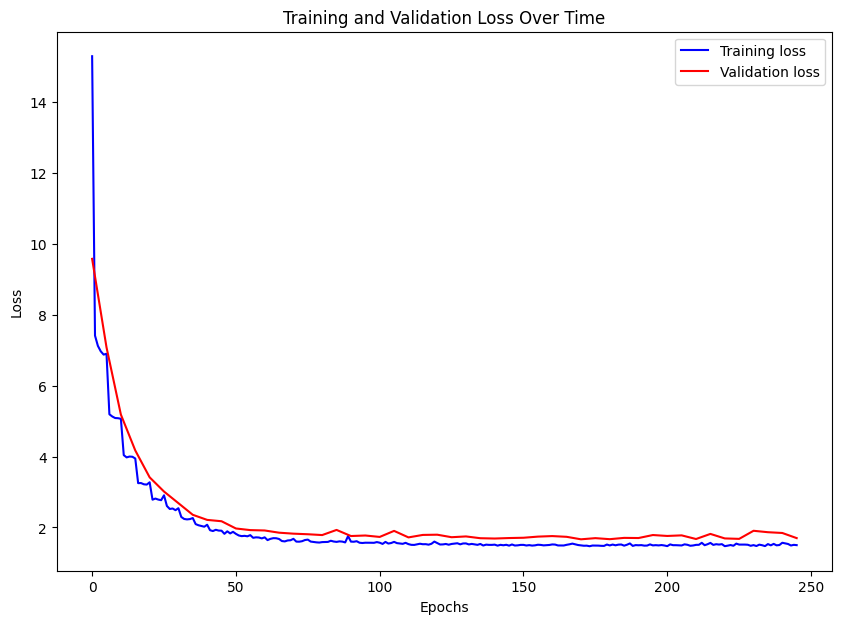

In [ ]:
plot_losses(train_losses, val_losses)

tensor(31.7755) tensor(2.8985)
validation MSE and MAE of block 237 : 236.31785583496094 , 12.33775806427002 
validation MSE and MAE of block 237 : 236.68128967285156 , 12.286283493041992 
validation MSE and MAE of block 236 : 238.4542999267578 , 12.26346206665039 
Calculate the MAE of the validation outputs and validation data
torch.Size([85, 16, 27, 8])
Maximum MSE: 15.755790710449219


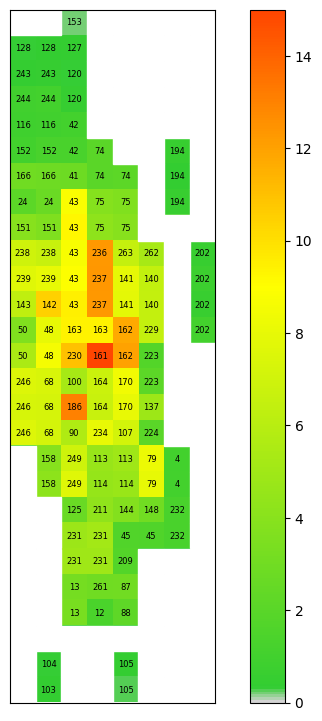

In [ ]:
show_loss(model , val_pu_ts , val_do , val_labels , taxi_zone_map , device)

##### Hyper-Para Tunning

In [ ]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, randint
import numpy as np

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[16,16,out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 5
initial_layers = 4

# Define the hyperparameters distributions to sample from
param_distributions = {
    # 'batch_size': [32, 64, 128],
    # 'lr':0.001,
    'initial_layers': randint(low= 1 , high= 10),
    # 'num_layers' : randint(low= 1 , high= 7),
    # 'hidden_dim' : [8,16,32,64] ,
    # 'hidden_dim' :randint(low= 2 , high= 128),
    # you can add other parameters here
}

# Specify the number of iterations for the random search
n_iter = 10

# Create a random sampler of parameters
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter))


best_model = None
best_model_params = None
best_val_loss = float('inf')

for params in param_list:
    print('-' * 10)
    print(f"Training with parameters: {params}")
    params['hidden_dim'] = 16
    params['hidden_dim'] = 1
    params['lr'] = 0.001

    initial_layers = params['initial_layers']
    num_layers = params['hidden_dim']
    hidden_dim = (num_layers-1) * [params['hidden_dim']] + [out_dim]


    # Create a new instance of the model
    model = DeepShallowConvLSTM3(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, window, initial_layers ).to(device)

    # Create a new optimizer with the current learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

    # Define the number of training epochs
    num_epochs = 200
    validation_interval = 5
    patience = 10
    # Train the model and get the final validation loss
    model, train_losses, val_losses, earlystop_val_loss = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, print_losses= False)

    # If this is the best model so far, save it
    final_val_loss = earlystop_val_loss
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model
        best_model_params = params

print(f"**{'-' * 10}**")
print(f"Best Hyper-Paramter Tunning validation loss: {best_val_loss}, with parameters: {best_model_params}")


----------
Training with parameters: {'hidden_dim': 16, 'initial_layers': 9, 'num_layers': 1}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping
Epoch 161/200
Last Train Loss: 63.5768
Best Validation Loss: 52.3991
----------
Training with parameters: {'hidden_dim': 16, 'initial_layers': 3, 'num_layers': 2}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping
Epoch 166/200
Last Train Loss: 64.3452
Best Validation Loss: 53.1749
----------
Training with parameters: {'hidden_dim': 16, 'initial_layers': 9, 'num_layers': 3}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping
Epoch 106/200
Last Train Loss: 72.4463
Best Validation Loss: 60.7328
----------
Training with parameters: {'hidden_dim': 32, 'initial_layers': 7, 'num_layers': 3}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping
Epoch 151/200
Last Train Loss: 70.8813
Best Validation Loss: 57.3911
----------
Training with parameters: {'hidden_dim': 32, 'initial_layers': 2, 'num_layers': 3}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping
Epoch 121/200
Last Train Loss: 68.3453
Best Validation Loss: 54.8298
----------
Training with parameters: {'hidden_dim': 8, 'initial_layers': 1, 'num_layers': 1}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping
Epoch 116/200
Last Train Loss: 60.7425
Best Validation Loss: 50.7931
----------
Training with parameters: {'hidden_dim': 16, 'initial_layers': 5, 'num_layers': 1}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping
Epoch 111/200
Last Train Loss: 78.7804
Best Validation Loss: 63.6046
----------
Training with parameters: {'hidden_dim': 32, 'initial_layers': 1, 'num_layers': 6}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200/200
Last Train Loss: 61.1502
Best Validation Loss: 49.7711
----------
Training with parameters: {'hidden_dim': 8, 'initial_layers': 9, 'num_layers': 5}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200/200
Last Train Loss: 49.1358
Best Validation Loss: 41.0618
----------
Training with parameters: {'hidden_dim': 16, 'initial_layers': 7, 'num_layers': 1}


Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200/200
Last Train Loss: 63.1608
Best Validation Loss: 52.0126
**----------**
Best Hyper-Paramter Tunning validation loss: 41.061805725097656, with parameters: {'hidden_dim': 8, 'initial_layers': 9, 'num_layers': 5, 'lr': 0.001}


### 5.0 ConvSelfAttention



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvSelfAttentionCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size,  height =27, width=8 ,  bias= True):
        super(ConvSelfAttentionCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.height = height
        self.width = width

        self.query_conv = nn.Conv2d(in_channels=self.input_dim,
                                    out_channels=self.hidden_dim,
                                    kernel_size=self.kernel_size,
                                    padding=self.padding,
                                    bias=self.bias)

        self.key_conv = nn.Conv2d(in_channels=self.input_dim,
                                  out_channels=self.hidden_dim,
                                  kernel_size=self.kernel_size,
                                  padding=self.padding,
                                  bias=self.bias)

        self.value_conv = nn.Conv2d(in_channels=self.input_dim,
                                    out_channels=self.hidden_dim,
                                    kernel_size=self.kernel_size,
                                    padding=self.padding,
                                    bias=self.bias)

        self.concat_conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim ,
                                    out_channels=self.hidden_dim,
                                    kernel_size=self.kernel_size,
                                    padding=self.padding,
                                    bias=self.bias)

        self.layer_norm = nn.LayerNorm([hidden_dim, self.height, self.width])

    def forward(self, input_tensor):
        # input_tensor shape: [batch_size, window_size, channels, height, width]
        batch_size, seq_len, _, height, width = input_tensor.size()

        # reshape to: [batch_size * window_size, channels, height, width]
        input_tensor = input_tensor.view(batch_size*seq_len, -1, height, width)

        # project the input tensor to query, key, and value tensors
        proj_query = self.query_conv(input_tensor).view(batch_size, seq_len, -1, width*height).permute(0, 2, 1, 3)  # B x C x seq_len x (H*W)
        proj_key = self.key_conv(input_tensor).view(batch_size, seq_len, -1, width*height).permute(0, 2, 3, 1) # B x C x (H*W) x seq_len
        proj_value = self.value_conv(input_tensor).view(batch_size, seq_len, -1, width*height).permute(0, 2, 1, 3)  # B x C x seq_len x (H*W)


        # calculate the attention scores
        energy = torch.matmul(proj_query, proj_key)  # B x C x seq_len x seq_len
        attention = F.softmax(energy, dim=-1)  # softmax over the last dimension


        # apply the attention scores to the value tensor
        out = torch.matmul(attention, proj_value)  # B x C x seq_len x (H*W)
        out = out.view(batch_size*seq_len, -1, height, width) # reshape to: [batch_size * window_size, channels, height, width]
        # out = out.view(batch_size, seq_len, -1, height, width)  # reshape to the original size

        concat_out =  self.concat_conv(torch.cat((input_tensor, out), dim=1))
        concat_out = concat_out.view(batch_size, seq_len, -1, height, width)  # reshape to the original size
        concat_out = self.layer_norm(concat_out)

        # print(f"ConvSelfAttentionCell input: {input_tensor.shape} \n proj_query : {proj_query.shape} , proj_key : {proj_key.shape} , proj_value: {proj_value.shape} ")
        # print(f"energy: {energy.shape}, attention : {attention.shape} \n out : {out.shape} , concat_out : {concat_out.shape} ")

        return concat_out

class ConvSelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_size , window):
        super(ConvSelfAttention, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.height, self.width = tensor_size
        self.window = window

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = True
        self.bias = True
        self.return_all_layers = False

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvSelfAttentionCell(input_dim=cur_input_dim,
                                                   hidden_dim=self.hidden_dim[i],
                                                   kernel_size=self.kernel_size[i],
                                                   height =  self.height,
                                                   width = self.width,
                                                   bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

        self.conv1 = nn.Conv2d(in_channels=in_channels//2, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=out_channels*2, out_channels=out_channels, kernel_size=3, padding=1)

    def forward(self, input_tensor, input_standalone):
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        layer_output_list = [input_tensor]
        for layer_idx in range(self.num_layers):

            # print(f"input_tensor of {layer_idx} is  {input_tensor.shape}")
            h = self.cell_list[layer_idx](layer_output_list[-1])
            layer_output_list.append(h)

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]

        # Now process the input_tensor through the ConvSelfAttention and the standalone input through a separate Conv2D
        conv_out = self.conv1(layer_output_list[0][:, -1, :, :, :])
        standalone_out = self.conv2(input_standalone)

        # Concatenate the outputs along the channel dimension
        combined_out = torch.cat((conv_out, standalone_out), dim=1)

        # Pass the concatenated output through another Conv2D to get the final output
        final_out = self.conv3(combined_out)

        return final_out

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


In [ ]:
input_dim = 16
kernel_size = (3,3)
num_layers = 3
hidden_dim=[64, 64,  8]
in_channels = 16
out_channels = 16
window = 5

#  ConvLSTM(input_dim=channels,
#                  hidden_dim=[64, 64,  8],
#                  kernel_size=(3, 3),
#                  num_layers=3,
#                  batch_first=True,
#                  bias=True,
#                  return_all_layers=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = ConvSelfAttention(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, (27,8) , window).to(device)

input1 = torch.randn(2 , 5, 16, 27, 8).to(device) # (batch , days (window)  , min_int (channels) , x , y )
input2 = torch.randn(2 , 16, 27, 8).to(device) # (batch , days (window)  , min_int (channels) , x , y )

model(input1,input2).shape

torch.Size([2, 16, 27, 8])

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the CNNRNN
model = ConvSelfAttention(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:]  , window ).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
scheduler = None
num_epochs = 500
validation_interval = 5
patience = 10
model, train_losses, val_losses, _ = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, validation_interval=validation_interval , patience = patience, scheduler = scheduler)

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500
----------
Train Loss: 14.0386
Validation Loss: 8.7476
Validation loss decreased (inf --> 8.747649).  Saving model ...
Epoch 6/500
----------
Train Loss: 6.1540
Validation Loss: 6.0242
Validation loss decreased (8.747649 --> 6.024174).  Saving model ...
Epoch 11/500
----------
Train Loss: 4.0087
Validation Loss: 4.1277
Validation loss decreased (6.024174 --> 4.127678).  Saving model ...
Epoch 16/500
----------
Train Loss: 3.0401
Validation Loss: 3.1813
Validation loss decreased (4.127678 --> 3.181332).  Saving model ...
Epoch 21/500
----------
Train Loss: 2.5261
Validation Loss: 2.6772
Validation loss decreased (3.181332 --> 2.677224).  Saving model ...
Epoch 26/500
----------
Train Loss: 2.2432
Validation Loss: 2.3782
Validation loss decreased (2.677224 --> 2.378164).  Saving model ...
Epoch 31/500
----------
Train Loss: 2.0492
Validation Loss: 2.3345
Validation loss decreased (2.378164 --> 2.334451).  Saving model ...
Epoch 36/500
----------
Train Loss: 1.9611
Validation 

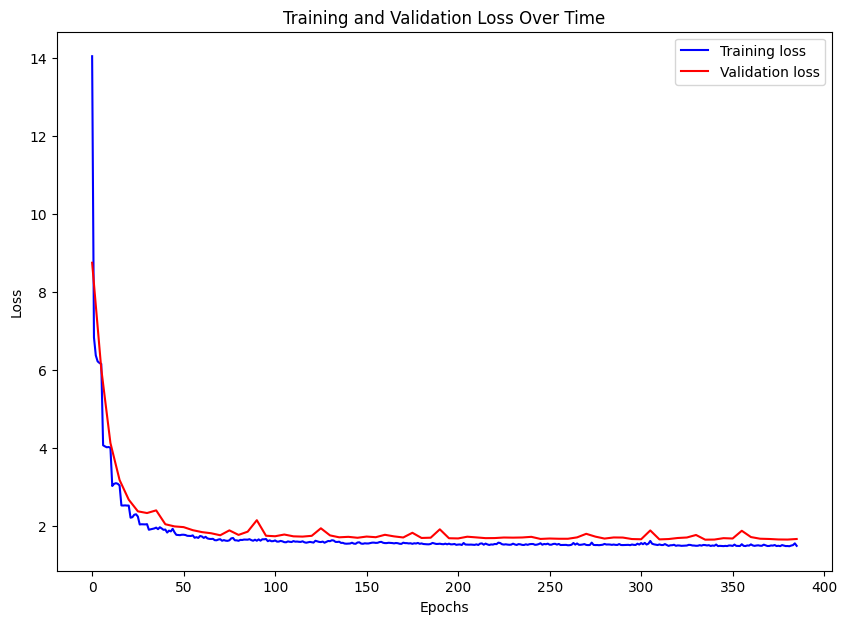

In [ ]:
plot_losses(train_losses, val_losses)

tensor(1.6695) tensor(0.4367)
validation MSE and MAE of block 237 (pixel) : 4.83443546295166 , 1.718719720840454 
validation MSE and MAE of block 237 : 38.67548370361328 , 13.749757766723633 
validation MSE and MAE of block 236 (pixel) : 7.591508865356445 , 2.181159496307373 
validation MSE and MAE of block 236 : 45.54905319213867 , 13.086956977844238 
Calculate the MAE of the validation outputs and validation data
torch.Size([146, 16, 58, 14])
Maximum MSE: 6.386964797973633


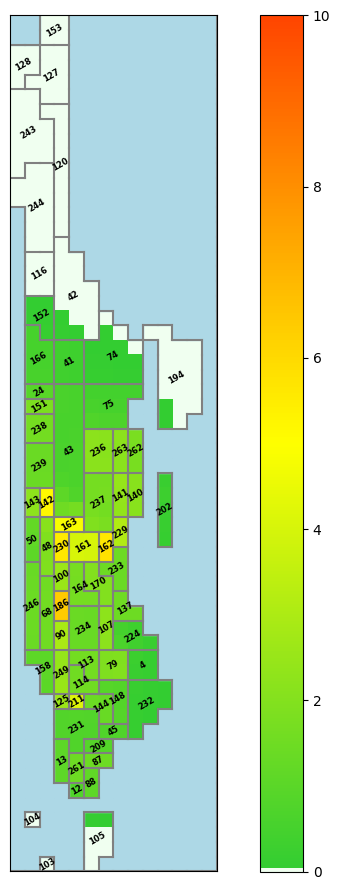

In [ ]:
show_loss(model , val_pu_ts , val_do , val_labels , taxi_zone_map , device)

### 6.0 Wide-Narrow:

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class TimeDistributedConv2dWideNarrow(nn.Module):
    def __init__(self, in_channels, out_channels, max_padding, min_padding, window):
        super(TimeDistributedConv2dWideNarrow, self).__init__()

        self.convs = nn.ModuleList()

        padding_decrement = (max_padding - min_padding) / (window - 1)

        for i in range(window):
            # Calculate the kernel size for this timestamp
            padding = max_padding - int(round(i * padding_decrement))
            kernel_size = 2*padding +1

            # Create a single convolutional layer with varying kernel size
            cnn = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                nn.ReLU()
            )
            self.convs.append(cnn)

    def forward(self, x):
        # We expect x to be of size (batch_size, window, channels, height, width)
        batch_size, window, channels, height, width = x.shape
        output = []
        for i in range(window):
            x_i = x[:, i]
            output_i = self.convs[i](x_i)
            output.append(output_i)
        return torch.stack(output, dim=1)


class WideNarrowConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window, max_padding, min_padding):
        super(WideNarrowConvLSTM, self).__init__()

        # self.conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)
        self.conv_lstm = ConvSelfAttention(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)


        self.time_distributed_cnn = TimeDistributedConv2dWideNarrow(in_channels=in_channels, out_channels=out_channels, max_padding=max_padding, min_padding=min_padding, window=window)
        self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)

    def forward(self, input_tensor, input_standalone):
        # Pass the input through the time-distributed CNN
        x = self.time_distributed_cnn(input_tensor)
        # pass the output + input_standalone through the ConvLSTM
        x = self.conv_lstm(x, input_standalone)
        # Pass the output through the final convolutional layer
        x = self.final_conv(x)
        return x


In [ ]:

input_dim = 16
kernel_size = (3,3)
num_layers = 3
hidden_dim=[64, 64,  8]
in_channels = 16
out_channels = 16
window = 5
max_padding = 9
min_padding = 0
print(f"kernal sizes: {2*max_padding +1}-{2*min_padding +1}")

model = WideNarrowConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, (27,8)  , window, max_padding , min_padding)

input1 = torch.randn(2 , 5, 16, 27,8 ) # (batch , days (window)  , min_int (channels) , x , y )
input2 = torch.randn(2 , 16, 27,8)  # (batch , days (window)  , min_int (channels) , x , y )

model(input1,input2).shape

kernal sizes: 19-1


torch.Size([2, 16, 27, 8])

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[ 16,16,  out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 7
max_padding = 5
min_padding = 0
print(f"kernal sizes: {2*max_padding +1}-{2*min_padding +1}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the CNNRNN
model = WideNarrowConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:]  , window, max_padding , min_padding).to(device)

model_num_params(model)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
num_epochs = 500
validation_interval = 5
patience = 10
model, train_losses, val_losses, _  = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, validation_interval=validation_interval , patience = patience, print_losses= False)

kernal sizes: 11-1
Number of parameters: 140240


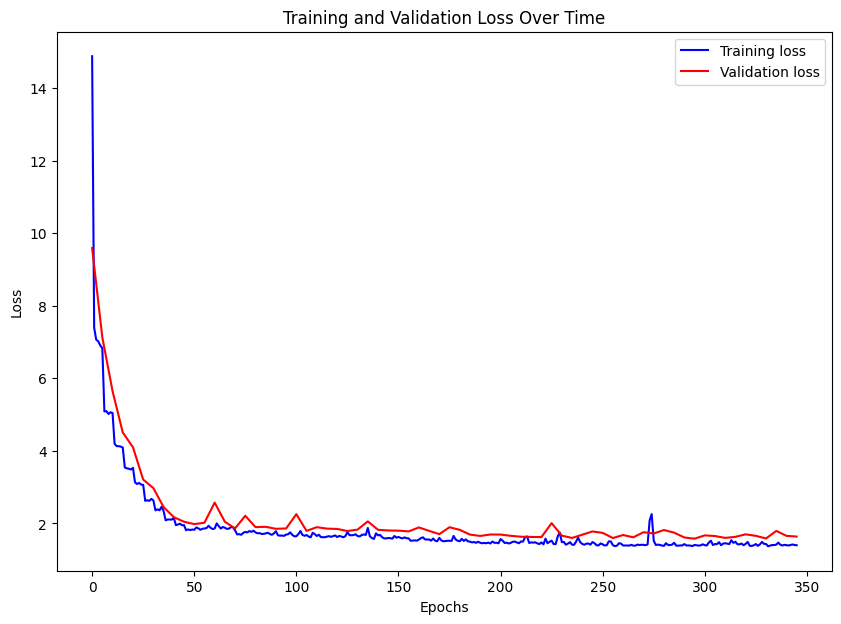

tensor(1.6376) tensor(0.4539)
validation MSE and MAE of block 237 (pixel) : 4.630716800689697 , 1.6673401594161987 
validation MSE and MAE of block 237 : 37.04573440551758 , 13.33872127532959 
validation MSE and MAE of block 236 (pixel) : 8.136762619018555 , 2.235612154006958 
validation MSE and MAE of block 236 : 48.82057571411133 , 13.413673400878906 
Calculate the MAE of the validation outputs and validation data
torch.Size([144, 16, 58, 14])
Maximum MSE: 6.371516227722168


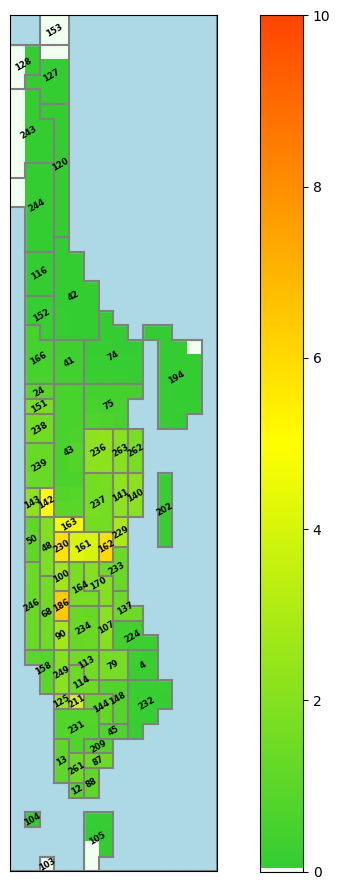

In [ ]:
plot_losses(train_losses, val_losses)
show_loss(model , val_pu_ts , val_do , val_labels , taxi_zone_map , device)

##### Hyper-Parametert Tunning:

In [ ]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, randint
import numpy as np

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[ 16,16,  out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 7
max_padding = 5
min_padding = 0
print(f"kernal sizes: {2*max_padding +1}-{2*min_padding +1}")

# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the hyperparameters distributions to sample from
param_distributions = {
    # 'batch_size': [32, 64, 128],
    # 'lr':0.001,
    # 'initial_layers': randint(low= 1 , high= 10),
    'num_layers' : randint(low= 1 , high= 4),
    'hidden_dim' : [16,32,64] ,
    # 'hidden_dim' :randint(low= 2 , high= 128),
    # you can add other parameters here
}

# Specify the number of iterations for the random search
n_iter = 20

# Create a random sampler of parameters
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter))




best_model = None
best_model_params = None
best_val_loss = float('inf')

for params in param_list:
    print('-' * 10)
    print(f"Training with parameters: {params}")
    # params['hidden_dim'] = 16
    # params['hidden_dim'] = 1
    # params['lr'] = 0.001

    num_layers = params['num_layers']
    hidden_dim = (num_layers-1) * [params['hidden_dim']] + [out_dim]
    print(hidden_dim)


    model = WideNarrowConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:]  , window, max_padding , min_padding).to(device)
    model_num_params(model)

    # Create a new optimizer with the current learning rate
    optimizer = torch.optim.Adam(model.parameters()) #, lr=params['lr'])
    criterion = nn.MSELoss()


    # Define the number of training epochs
    num_epochs = 500
    validation_interval = 5
    patience = 10
    # Train the model and get the final validation loss
    model, train_losses, val_losses, earlystop_val_loss = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, print_losses= False)

    # If this is the best model so far, save it
    final_val_loss = earlystop_val_loss
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model
        best_model_params = params

print(f"**{'-' * 10}**")
print(f"Best Hyper-Paramter Tunning validation loss: {best_val_loss}, with parameters: {best_model_params}")


kernal sizes: 11-1
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 3}
[32, 32, 8]
Number of parameters: 237136


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 151/500
Last Train Loss: 1.5033
Best Validation Loss: 1.8093
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 2}
[32, 8]
Number of parameters: 163280


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 256/500
Last Train Loss: 1.3261
Best Validation Loss: 1.6387
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 2}
[32, 8]
Number of parameters: 163280


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 266/500
Last Train Loss: 1.2867
Best Validation Loss: 1.6153
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 596816


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 296/500
Last Train Loss: 1.3409
Best Validation Loss: 1.6508
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 301648


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 411/500
Last Train Loss: 1.2384
Best Validation Loss: 1.5548
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 1}
[8]
Number of parameters: 103248


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 381/500
Last Train Loss: 1.3014
Best Validation Loss: 1.6118
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 3}
[32, 32, 8]
Number of parameters: 237136


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 276/500
Last Train Loss: 1.3503
Best Validation Loss: 1.6332
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 301648


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 196/500
Last Train Loss: 1.4380
Best Validation Loss: 1.7476
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 1}
[8]
Number of parameters: 103248


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 181/500
Last Train Loss: 1.4381
Best Validation Loss: 1.7263
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 3}
[16, 16, 8]
Number of parameters: 140240


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 361/500
Last Train Loss: 1.3539
Best Validation Loss: 1.6552
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 1}
[8]
Number of parameters: 103248


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 431/500
Last Train Loss: 1.3606
Best Validation Loss: 1.6078
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 2}
[32, 8]
Number of parameters: 163280


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 291/500
Last Train Loss: 1.3909
Best Validation Loss: 1.6850
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 2}
[16, 8]
Number of parameters: 121744


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 306/500
Last Train Loss: 1.3610
Best Validation Loss: 1.6363
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 3}
[32, 32, 8]
Number of parameters: 237136


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 326/500
Last Train Loss: 1.3853
Best Validation Loss: 1.6700
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 3}
[32, 32, 8]
Number of parameters: 237136


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 176/500
Last Train Loss: 1.4851
Best Validation Loss: 1.7787
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 301648


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 171/500
Last Train Loss: 1.4959
Best Validation Loss: 1.7639
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 1}
[8]
Number of parameters: 103248


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 276/500
Last Train Loss: 1.3275
Best Validation Loss: 1.6501
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 3}
[32, 32, 8]
Number of parameters: 237136


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 206/500
Last Train Loss: 1.4075
Best Validation Loss: 1.7029
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 1}
[8]
Number of parameters: 103248


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 256/500
Last Train Loss: 1.3546
Best Validation Loss: 1.6525
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 2}
[64, 8]
Number of parameters: 301648


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 311/500
Last Train Loss: 1.3123
Best Validation Loss: 1.6082
**----------**
Best Hyper-Paramter Tunning validation loss: 1.5547863907284207, with parameters: {'hidden_dim': 64, 'num_layers': 2}


In [ ]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, randint
import numpy as np

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[ 16,16,  out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 7
max_padding = 5
min_padding = 0
print(f"kernal sizes: {2*max_padding +1}-{2*min_padding +1}")

# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the hyperparameters distributions to sample from
param_distributions = {
    # 'batch_size': [32, 64, 128],
    # 'lr':0.001,
    # 'initial_layers': randint(low= 1 , high= 10),
    'num_layers' : randint(low= 1 , high= 4),
    'hidden_dim' : [16,32,64] ,
    # 'hidden_dim' :randint(low= 2 , high= 128),
    # you can add other parameters here
}

# Specify the number of iterations for the random search
n_iter = 20

# Create a random sampler of parameters
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter))




best_model = None
best_model_params = None
best_val_loss = float('inf')

for params in param_list:
    print('-' * 10)
    print(f"Training with parameters: {params}")
    # params['hidden_dim'] = 16
    # params['hidden_dim'] = 1
    # params['lr'] = 0.001

    num_layers = params['num_layers']
    hidden_dim = (num_layers-1) * [params['hidden_dim']] + [out_dim]
    print(hidden_dim)


    model = WideNarrowConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:]  , window, max_padding , min_padding).to(device)
    model_num_params(model)

    # Create a new optimizer with the current learning rate
    optimizer = torch.optim.Adam(model.parameters()) #, lr=params['lr'])
    criterion = nn.MSELoss()


    # Define the number of training epochs
    num_epochs = 500
    validation_interval = 5
    patience = 10
    # Train the model and get the final validation loss
    model, train_losses, val_losses, earlystop_val_loss = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, validation_interval, patience, print_losses= False)

    # If this is the best model so far, save it
    final_val_loss = earlystop_val_loss
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = model
        best_model_params = params

print(f"**{'-' * 10}**")
print(f"Best Hyper-Paramter Tunning validation loss: {best_val_loss}, with parameters: {best_model_params}")


kernal sizes: 11-1
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 2}
[32, 8]
Number of parameters: 198864


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 216/500
Last Train Loss: 1.3985
Best Validation Loss: 1.6216
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 3}
[32, 32, 8]
Number of parameters: 297040


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 236/500
Last Train Loss: 1.6426
Best Validation Loss: 1.7816
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 1}
[8]
Number of parameters: 114512


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 391/500
Last Train Loss: 1.4272
Best Validation Loss: 1.5554
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 2}
[32, 8]
Number of parameters: 198864


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 221/500
Last Train Loss: 1.4437
Best Validation Loss: 1.6063
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 3}
[64, 64, 8]
Number of parameters: 594768


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 201/500
Last Train Loss: 1.7328
Best Validation Loss: 1.8236
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 3}
[32, 32, 8]
Number of parameters: 297040


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 241/500
Last Train Loss: 1.5605
Best Validation Loss: 1.7412
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 1}
[8]
Number of parameters: 114512


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 201/500
Last Train Loss: 1.4372
Best Validation Loss: 1.5882
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 1}
[8]
Number of parameters: 114512


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 226/500
Last Train Loss: 1.4895
Best Validation Loss: 1.6414
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 2}
[32, 8]
Number of parameters: 198864


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 321/500
Last Train Loss: 1.3258
Best Validation Loss: 1.5229
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 3}
[32, 32, 8]
Number of parameters: 297040


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 156/500
Last Train Loss: 1.7217
Best Validation Loss: 1.8405
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 2}
[32, 8]
Number of parameters: 198864


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 361/500
Last Train Loss: 1.4071
Best Validation Loss: 1.5670
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 1}
[8]
Number of parameters: 114512


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 226/500
Last Train Loss: 1.3933
Best Validation Loss: 1.5818
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 3}
[16, 16, 8]
Number of parameters: 189648


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 266/500
Last Train Loss: 1.4256
Best Validation Loss: 1.6331
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 3}
[16, 16, 8]
Number of parameters: 189648


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 261/500
Last Train Loss: 1.4735
Best Validation Loss: 1.6762
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 3}
[16, 16, 8]
Number of parameters: 189648


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 316/500
Last Train Loss: 1.4306
Best Validation Loss: 1.6233
----------
Training with parameters: {'hidden_dim': 32, 'num_layers': 1}
[8]
Number of parameters: 114512


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 236/500
Last Train Loss: 1.4159
Best Validation Loss: 1.5816
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 2}
[16, 8]
Number of parameters: 152080


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 171/500
Last Train Loss: 1.5009
Best Validation Loss: 1.6810
----------
Training with parameters: {'hidden_dim': 64, 'num_layers': 1}
[8]
Number of parameters: 114512


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 366/500
Last Train Loss: 1.3811
Best Validation Loss: 1.5518
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 2}
[16, 8]
Number of parameters: 152080


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 226/500
Last Train Loss: 1.4728
Best Validation Loss: 1.6388
----------
Training with parameters: {'hidden_dim': 16, 'num_layers': 3}
[16, 16, 8]
Number of parameters: 189648


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 496/500
Last Train Loss: 1.3567
Best Validation Loss: 1.5221
**----------**
Best Hyper-Paramter Tunning validation loss: 1.5220667521158855, with parameters: {'hidden_dim': 16, 'num_layers': 3}


#### 6.1 + Normalization:

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F


class TimeDistributedConv2dWideNarrow(nn.Module):
    def __init__(self, in_channels, out_channels, max_padding, min_padding, window):
        super(TimeDistributedConv2dWideNarrow, self).__init__()

        self.convs = nn.ModuleList()

        padding_decrement = (max_padding - min_padding) / (window - 1)

        for i in range(window):
            # Calculate the kernel size for this timestamp
            padding = max_padding - int(round(i * padding_decrement))
            kernel_size = 2*padding +1

            # Create a single convolutional layer with varying kernel size
            cnn = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                nn.ReLU()
            )
            self.convs.append(cnn)

    def forward(self, x):
        # We expect x to be of size (batch_size, window, channels, height, width)
        batch_size, window, channels, height, width = x.shape
        output = []
        for i in range(window):
            x_i = x[:, i]
            output_i = self.convs[i](x_i)
            output.append(output_i)
        return torch.stack(output, dim=1)


class WideNarrowConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window, max_padding, min_padding):
        super(WideNarrowConvLSTM, self).__init__()

        # self.conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)
        self.conv_lstm = ConvSelfAttention(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)


        self.time_distributed_cnn = TimeDistributedConv2dWideNarrow(in_channels=in_channels, out_channels=out_channels, max_padding=max_padding, min_padding=min_padding, window=window)
        self.final_conv = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)

    def forward(self, input_tensor, input_standalone):
        # Pass the input through the time-distributed CNN
        x = self.time_distributed_cnn(input_tensor)
        # pass the output + input_standalone through the ConvLSTM
        x = self.conv_lstm(x, input_standalone)
        # Pass the output through the final convolutional layer
        x = self.final_conv(x)
        return x


### 7. LargeSmall

In [ ]:
import torch
import torch.nn as nn

class TimeDistributedConv2dLargeSmall(nn.Module):
    def __init__(self, in_channels, max_out_channels, min_out_channels, window, kernel_size, padding):
        super(TimeDistributedConv2dLargeSmall, self).__init__()

        self.convs = nn.ModuleList()
        channel_decrement = (max_out_channels - min_out_channels) / (window - 1)

        for i in range(window):
            # Calculate the out_channels for this timestamp
            out_channels = max_out_channels - int(round(i * channel_decrement))

            # The first CNN with varying out_channels
            cnn1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding)

            # The second CNN to bring channel size back to in_channels
            cnn2 = nn.Conv2d(in_channels=out_channels, out_channels=in_channels, kernel_size=kernel_size, padding=padding)

            # Create a sequential model representing the layers of this CNN
            cnn = nn.Sequential(cnn1, nn.ReLU(), cnn2, nn.ReLU())
            self.convs.append(cnn)

    def forward(self, x):
        batch_size, window, channels, height, width = x.shape
        output = []
        for i in range(window):
            x_i = x[:, i]
            output_i = self.convs[i](x_i)
            output.append(output_i)
        return torch.stack(output, dim=1)


class LargeSmallConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window, max_out_channels, min_out_channels):
        super(LargeSmallConvLSTM, self).__init__()

        # self.conv_lstm = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)
        self.conv_lstm = ConvSelfAttention(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_shape, window)

        self.time_distributed_cnn = TimeDistributedConv2dLargeSmall(in_channels=in_channels, max_out_channels=max_out_channels, min_out_channels=min_out_channels, window=window, kernel_size=3, padding=1)

        self.final_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)  # Adjusted the in_channels here to match the output of time_distributed_cnn

    def forward(self, input_tensor, input_standalone):
        x = self.time_distributed_cnn(input_tensor)
        x = self.conv_lstm(x, input_standalone)
        x = self.final_conv(x)
        return x


In [ ]:

input_dim = 16
kernel_size = (3,3)
num_layers = 3
hidden_dim=[64, 64,  8]
in_channels = 16
out_channels = 16
window = 7
max_out_channels = 64
min_out_channels = 8
print(f"Mid Channel sizes: {max_out_channels}-{min_out_channels}")

model = LargeSmallConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:]  , window, max_out_channels , min_out_channels)

input1 = torch.randn(2 , 7, 16, 58,14 ) # (batch , days (window)  , min_int (channels) , x , y )
input2 = torch.randn(2 , 16, 58,14 )  # (batch , days (window)  , min_int (channels) , x , y )

model(input1,input2).shape

Mid Channel sizes: 64-8


torch.Size([2, 16, 58, 14])

In [ ]:
import torch.optim as optim
from tqdm.autonotebook import tqdm
import torch.optim.lr_scheduler as lr_scheduler

input_dim = 16
kernel_size = (3,3)
out_dim = input_dim//2
hidden_dim=[ 16,16,  out_dim]
num_layers = len(hidden_dim)
in_channels = 16
out_channels = 16
window = 7
max_out_channels = 64
min_out_channels = 8
print(f"Mid Channel sizes: {max_out_channels}-{min_out_channels}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the CNNRNN
model = LargeSmallConvLSTM(input_dim, hidden_dim, kernel_size, num_layers, in_channels, out_channels, tensor_do.shape[-2:]  , window, max_out_channels , min_out_channels).to(device)

model_num_params(model)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Define the learning rate decay scheduler
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


# # Split the data into training and validation sets
train_do = torch.tensor(tensor_do, dtype=torch.float32)
train_pu_ts = torch.tensor(tensor_pu_ts, dtype=torch.float32)
train_labels = torch.tensor(tensor_pu, dtype=torch.float32)
val_do = torch.tensor(tensor_test_do, dtype=torch.float32)
val_pu_ts = torch.tensor(tensor_test_pu_ts, dtype=torch.float32)
val_labels = torch.tensor(tensor_test_pu, dtype=torch.float32)

# Define the batch size
batch_size = 64

# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_pu_ts, train_do, train_labels),
    batch_size=batch_size,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(val_pu_ts,val_do , val_labels),
    batch_size=batch_size,
    shuffle=False)


# Define the number of training epochs
num_epochs = 500
validation_interval = 5
patience = 10
model, train_losses, val_losses, _  = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs, validation_interval=validation_interval , patience = patience, print_losses= False)

Mid Channel sizes: 64-8
Number of parameters: 127308


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Early stopping
Epoch 461/500
Last Train Loss: 1.3250
Best Validation Loss: 1.6320


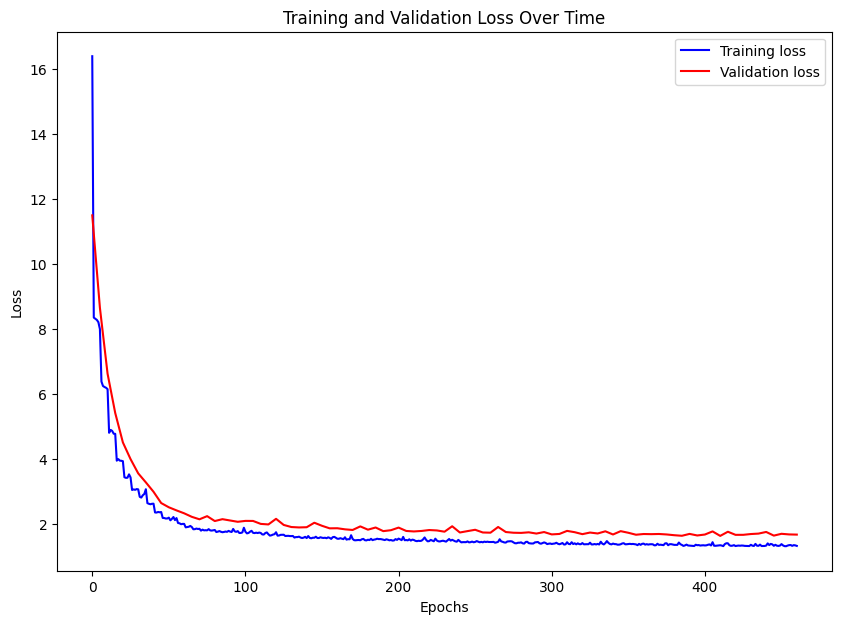

tensor(1.6719) tensor(0.4515)
validation MSE and MAE of block 237 (pixel) : 4.677056312561035 , 1.6961309909820557 
validation MSE and MAE of block 237 : 37.41645050048828 , 13.569047927856445 
validation MSE and MAE of block 236 (pixel) : 7.462036609649658 , 2.161524534225464 
validation MSE and MAE of block 236 : 44.772220611572266 , 12.969146728515625 
Calculate the MAE of the validation outputs and validation data
torch.Size([144, 16, 58, 14])
Maximum MSE: 6.159503936767578


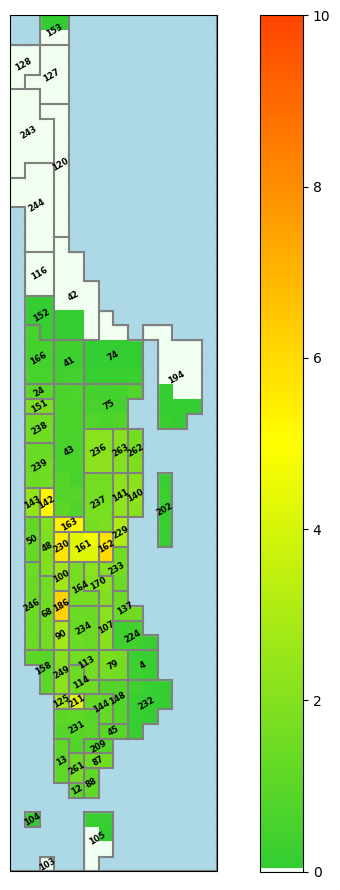

In [ ]:
plot_losses(train_losses, val_losses)
show_loss(model , val_pu_ts , val_do , val_labels , taxi_zone_map , device)